<a href="https://colab.research.google.com/github/Rachhh53/House-Prices-Advanced-Regression-Techniques-Kaggle/blob/main/house_prices_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [1]:
pip install dython

In [2]:
pip install pwlf

The dependent variable of interest is house prices in Ames, Iowa (‘SalePrice’). 

In [3]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif as MIC
from dython.nominal import associations, cluster_correlations
import statsmodels.api as sm
from google.colab import files
import pwlf
from scipy import optimize

# Figures inline and set visualization style
%matplotlib inline
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Import test and train datasets
df_train_orig = pd.read_csv('https://raw.githubusercontent.com/Rachhh53/House-Prices-Advanced-Regression-Techniques-Kaggle/main/train.csv')
df_test_orig = pd.read_csv('https://raw.githubusercontent.com/Rachhh53/House-Prices-Advanced-Regression-Techniques-Kaggle/main/test.csv')

# View first lines of training data
df_train_orig.head(n=4)

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal    208500
1   2          20       RL  ...        WD         Normal    181500
2   3          60       RL  ...        WD         Normal    223500
3   4          70       RL  ...        WD        Abnorml    140000

[4 rows x 81 columns]

In [5]:
# View first lines of test data
df_test_orig.head()

Id  MSSubClass MSZoning  ...  YrSold  SaleType SaleCondition
0  1461          20       RH  ...    2010        WD        Normal
1  1462          20       RL  ...    2010        WD        Normal
2  1463          60       RL  ...    2010        WD        Normal
3  1464          60       RL  ...    2010        WD        Normal
4  1465         120       RL  ...    2010        WD        Normal

[5 rows x 80 columns]

SalesPrice is omitted since it is our dependent variable.

In [6]:
print(f'Training Data shape: {df_train_orig.shape} \n Test Data shape: {df_test_orig.shape}')

Training Data shape: (1460, 81) 
 Test Data shape: (1459, 80)


In [7]:
# create a single dataframe to investigate
dataframes = [df_train_orig, df_test_orig]
df = pd.concat(dataframes)

In [8]:
df.head()

Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0   1          60       RL  ...        WD         Normal  208500.0
1   2          20       RL  ...        WD         Normal  181500.0
2   3          60       RL  ...        WD         Normal  223500.0
3   4          70       RL  ...        WD        Abnorml  140000.0
4   5          60       RL  ...        WD         Normal  250000.0

[5 rows x 81 columns]

In [9]:
df.shape

(2919, 81)

# EDA

<span style="color:blue">Observations:</span><br>
LotFrontage has <strong>259</strong> (1460-1201) missing values. <br>
Alley has <strong>1369</strong> (1460-91) missing values.<br>
MasVnrType has <strong>8</strong> (1460-1452) missing values.<br>
MasVnrArea has <strong>8</strong> (1460-1452) missing values.<br>
BsmtQual has <strong>37</strong> (1460-1423) missing values.<br>
BsmtCond has <strong>37</strong> (1460-1423) missing values.<br>
BsmtExposure has <strong>38</strong> (1460-1422) missing values.<br>
BsmtFinType1 has <strong>37</strong> (1460-1423) missing values.<br>
BsmtFinType2 has <strong>38</strong> (1460-1422) missing values.<br>
Electrical has <strong>1</strong> (1460-1459) missing value.<br>
FireplaceQu has <strong>690</strong> (1460-770) missing values.<br>
GarageType has <strong>81</strong> (1460-1379) missing values.<br>
GarageYrBlt has <strong>81</strong> (1460-1379) missing values.<br>
GarageFinish has <strong>81</strong> (1460-1379) missing values.<br>
GarageQual has <strong>81</strong> (1460-1379) missing values.<br>
GarageCond has <strong>81</strong> (1460-1379) missing values.<br>
PoolQC has <strong>1453</strong> (1460-7) missing values.<br>
Fence has <strong>1179</strong> (1460-281) missing values.<br>
MiscFeature has <strong>1406</strong> (1460-54) missing values.<br>

In [10]:
# credit: https://www.kaggle.com/gorkembakir/hp-eda
def plot_hist(variable):
    plt.figure(figsize=(7,3))
    plt.hist(df_train_orig[variable],bins=30)
    plt.xlabel(variable)
    plt.title("{}".format(variable))
    plt.show()

In [11]:
#divide columns in categorical and numerical ones to have a better overview
cat_columns = df.select_dtypes(include=['object']).columns.tolist()
num_columns = df.select_dtypes(exclude=['object']).columns.tolist()
print(f'Categorical columns: \n {cat_columns} \n Numerical columns: \n {num_columns}')

Categorical columns: 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] 
 Numerical columns: 
 ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars'

In [12]:
# we're using this to find correlations so we don't want anything that won't
# have a correlation with our dependent variable
df_cat = df_train_orig.select_dtypes(include='object')
df_cat['SalePrice'] = df_train_orig.loc[:,'SalePrice']
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 44 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          91 non-null     object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1452 non-null   object
 18  ExterQual      1460 non-null

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


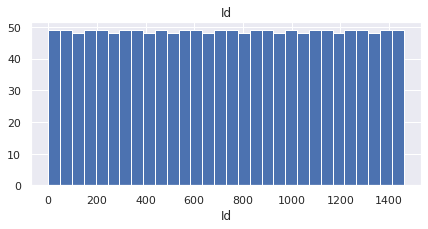

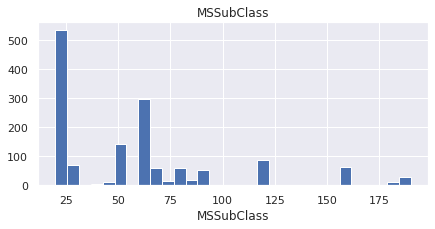

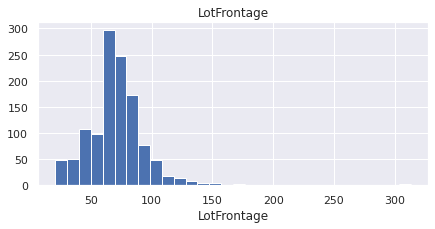

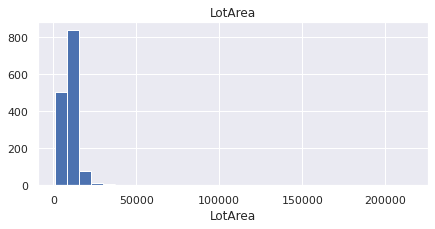

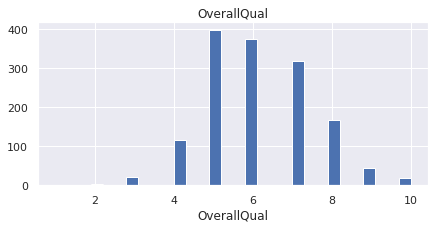

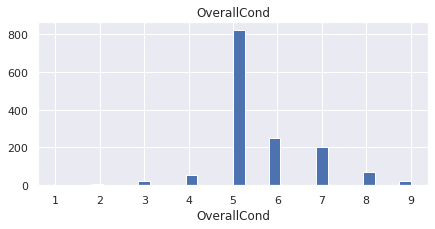

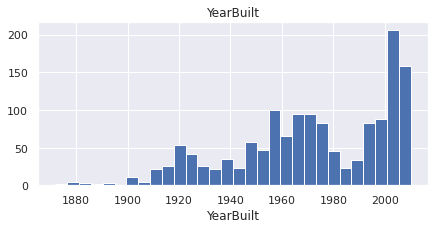

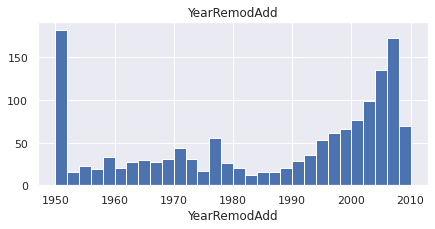

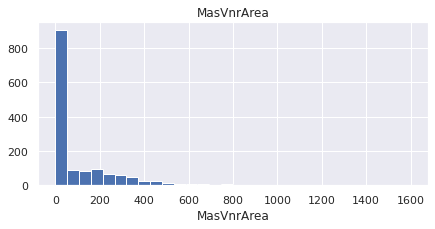

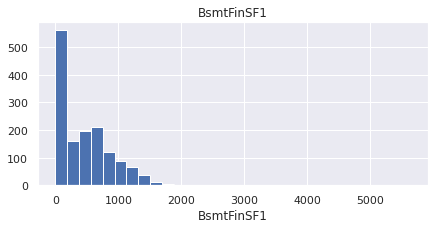

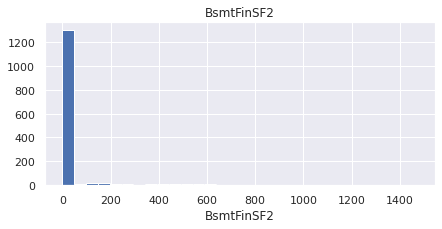

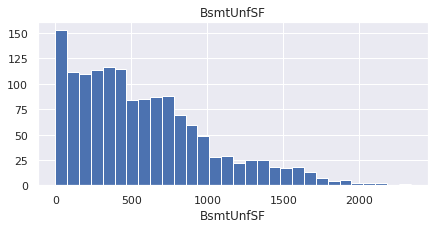

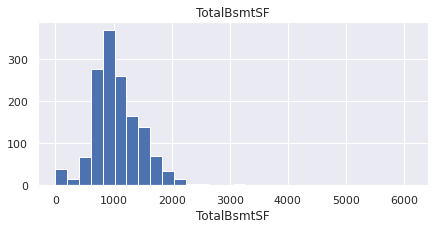

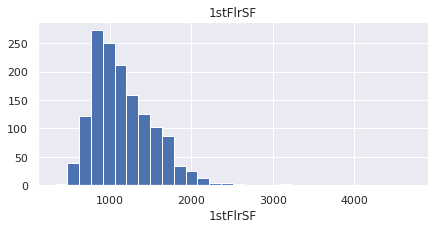

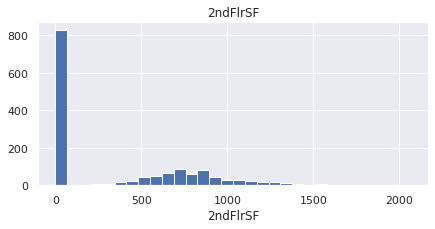

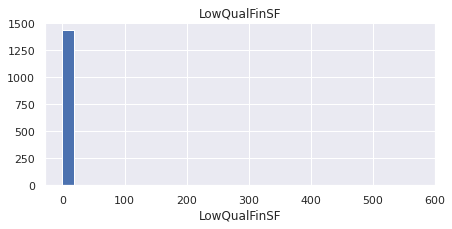

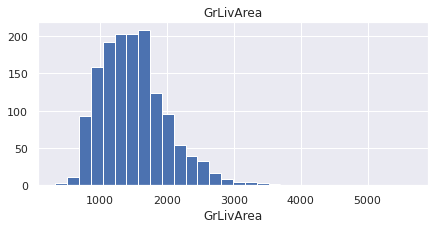

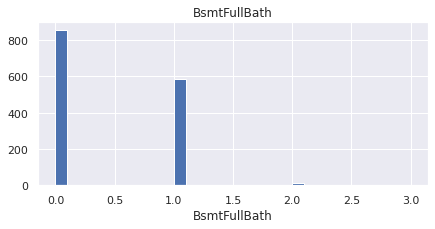

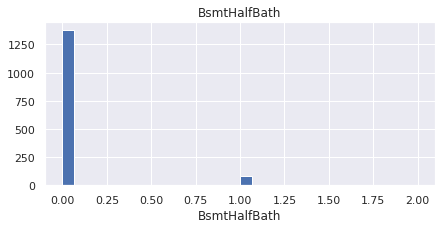

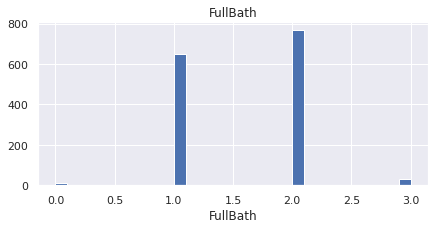

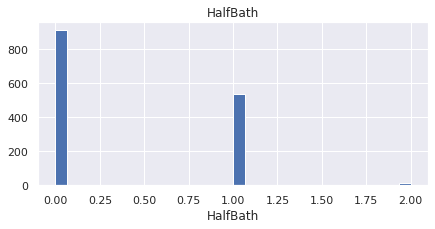

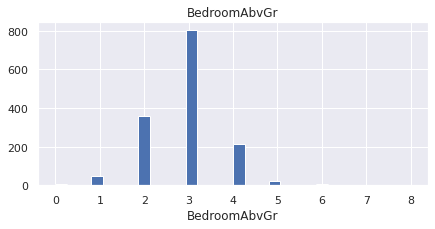

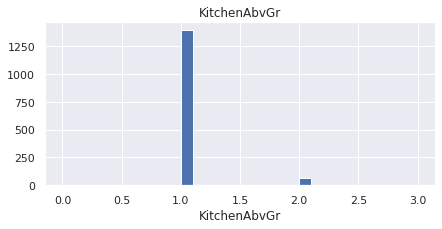

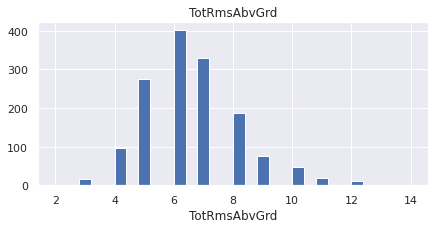

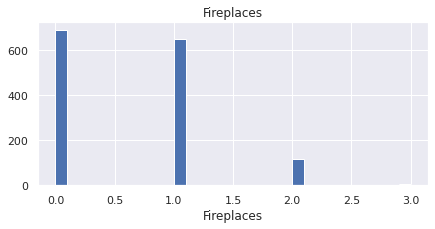

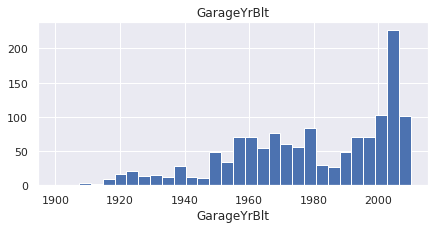

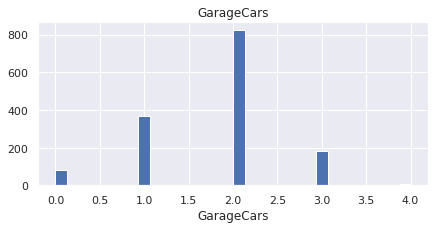

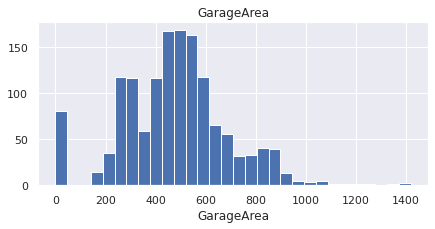

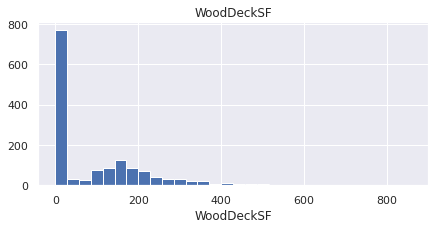

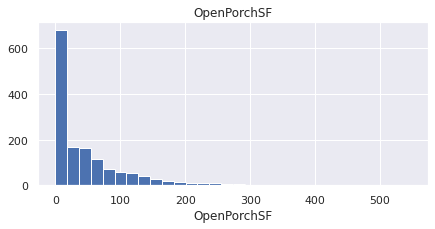

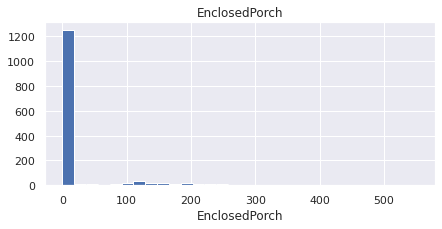

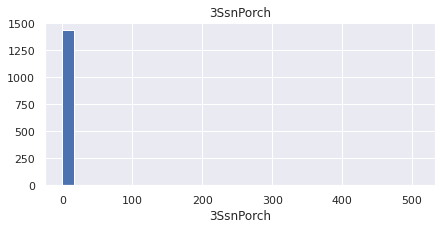

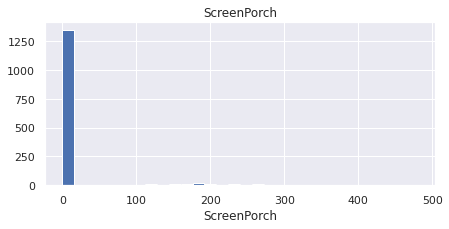

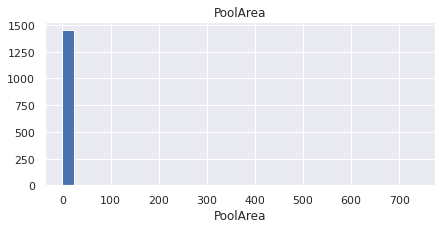

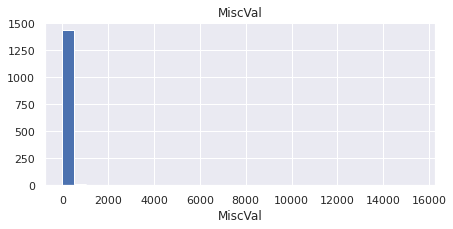

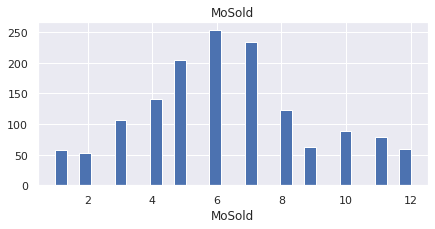

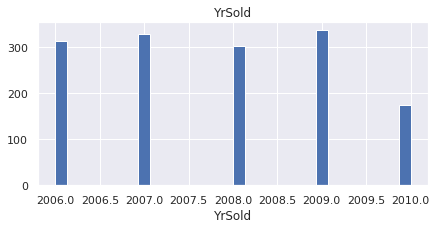

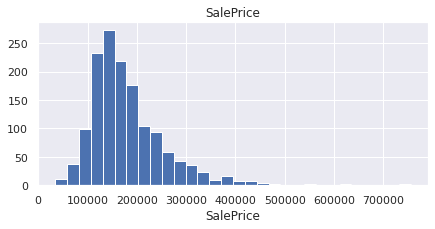

In [13]:
for n in num_columns:
    plot_hist(n)

<h3>1. Provide appropriate descriptive statistics and visualizations to help understand the marginal distribution of the dependent variable.</h3>

In [14]:
df.describe()

Id   MSSubClass  ...       YrSold      SalePrice
count  2919.000000  2919.000000  ...  2919.000000    1460.000000
mean   1460.000000    57.137718  ...  2007.792737  180921.195890
std     842.787043    42.517628  ...     1.314964   79442.502883
min       1.000000    20.000000  ...  2006.000000   34900.000000
25%     730.500000    20.000000  ...  2007.000000  129975.000000
50%    1460.000000    50.000000  ...  2008.000000  163000.000000
75%    2189.500000    70.000000  ...  2009.000000  214000.000000
max    2919.000000   190.000000  ...  2010.000000  755000.000000

[8 rows x 38 columns]

<h4>A linear regression fit and univariate KDE curves.</h4>

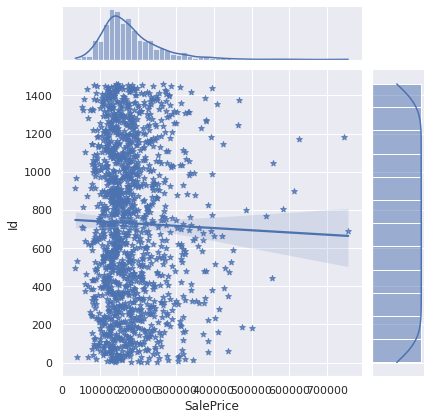

In [15]:
# here "*" is used as a marker for scatterplot
sns.jointplot(data=df_train_orig, x="SalePrice", y="Id", kind="reg", marker="*")

I used Id as the y-axis to ensure I saw all data about SalePrice without noise.<br>
<span style="color:blue">Observations:</span><br>
It looks like there are a few outliers at the highest sale price, leading to a long right tail, but the distibution is mostly normal for SalePrice.

<h3>2. Investigate missing data and outliers.</h3>

<h4>Missing Data</h4>

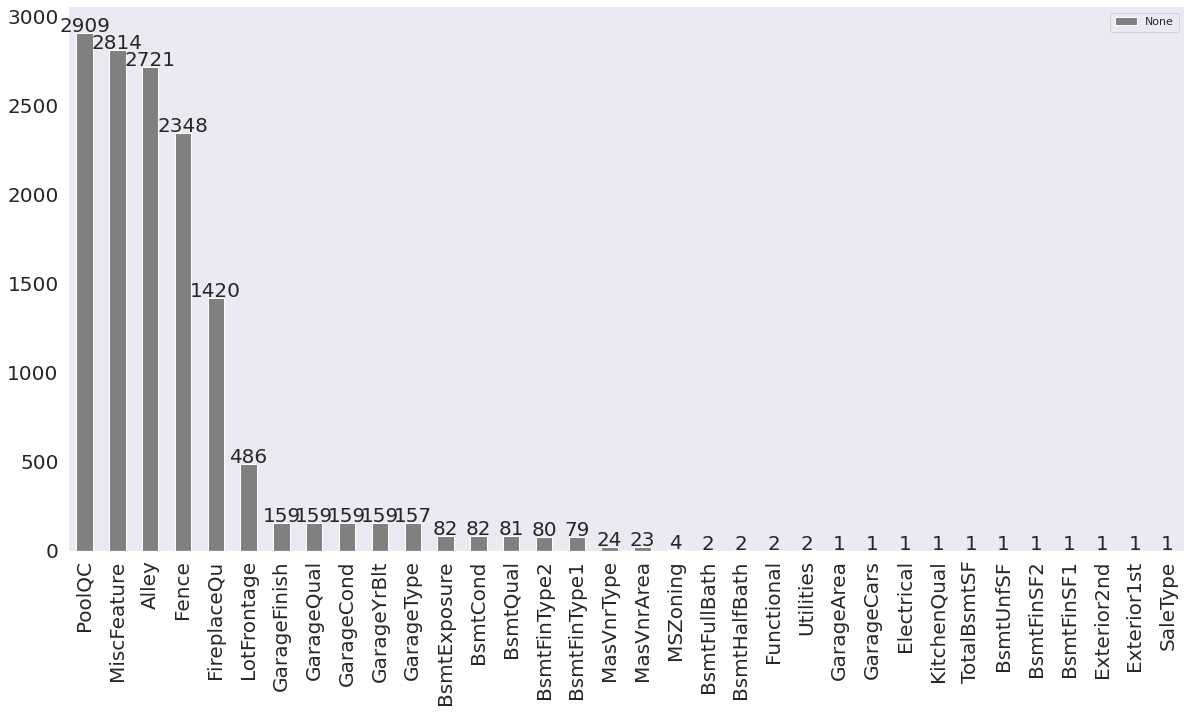

In [16]:
# credit: https://www.kaggle.com/ohseokkim/house-price-all-about-house-price
# .loc[:, ] sets a value for an entire column
isnull_series = df.loc[:,:'SaleCondition'].isnull().sum()
isnull_series[isnull_series > 0].sort_values(ascending=False)

plt.figure(figsize = (20,10))
ax = isnull_series[isnull_series > 0].sort_values(ascending=False).plot(kind='bar',
                                                                        grid = False,
                                                                        fontsize=20,
                                                                        color='grey')
plt.legend(loc = 'upper right')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 5, height, ha = 'center', size = 20)
sns.despine()

All the above features have missing data.

<h4>Outliers</h4>

In [17]:
def get_boxplots(feat):
    plt.figure()
    return sns.boxplot(x=df[feat])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


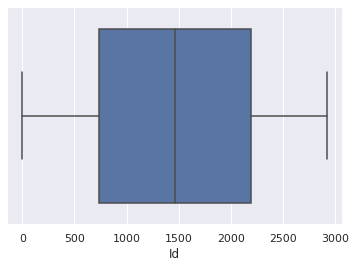

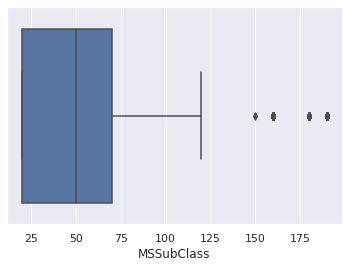

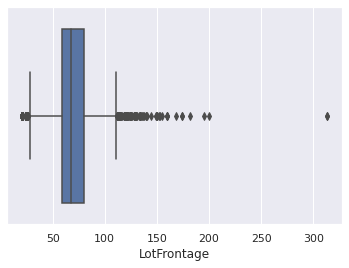

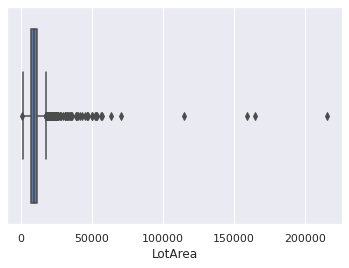

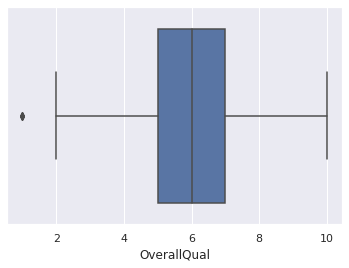

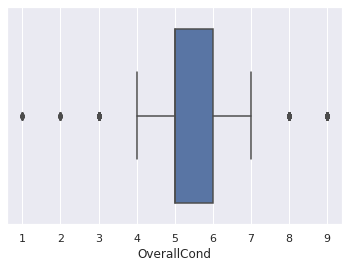

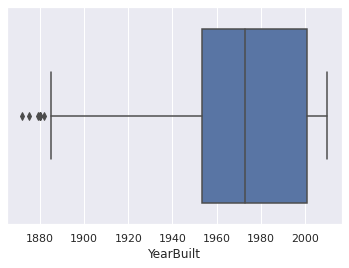

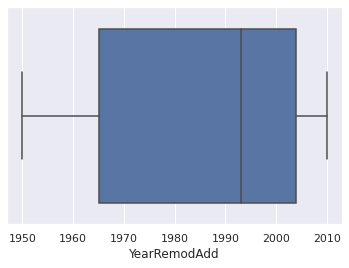

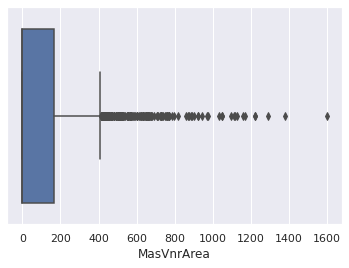

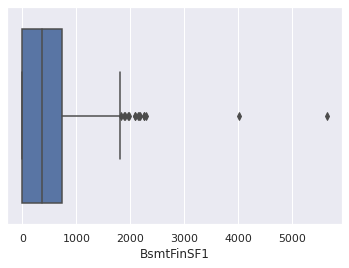

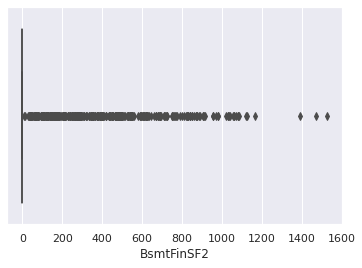

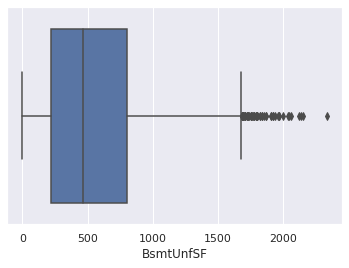

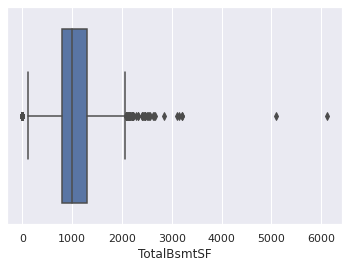

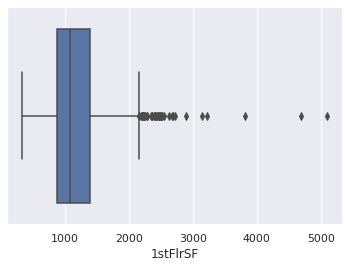

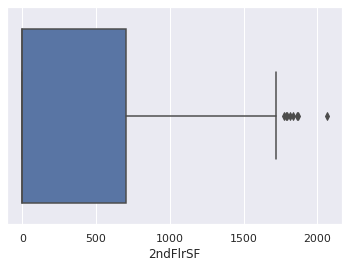

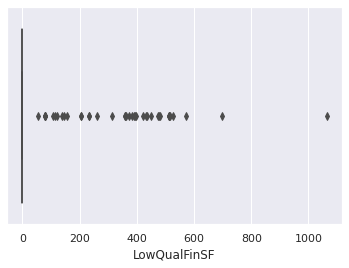

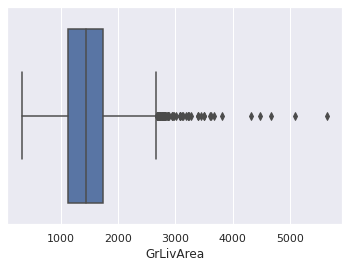

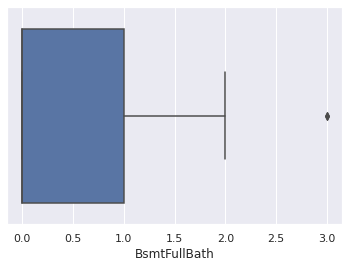

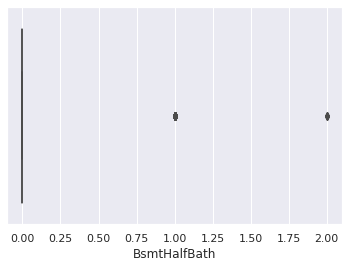

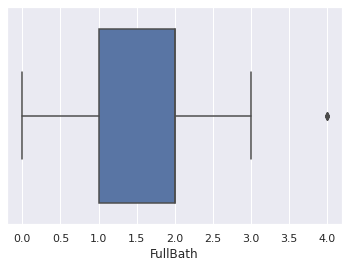

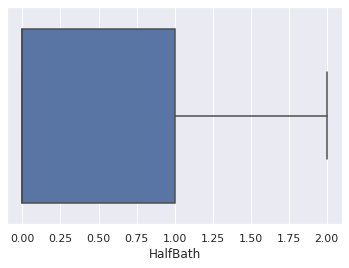

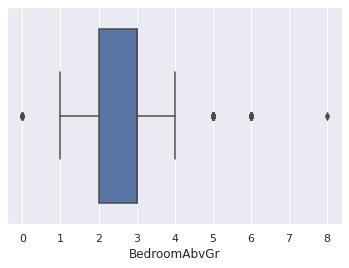

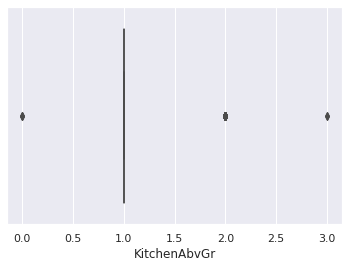

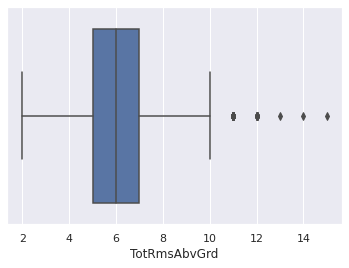

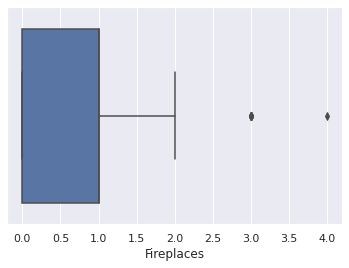

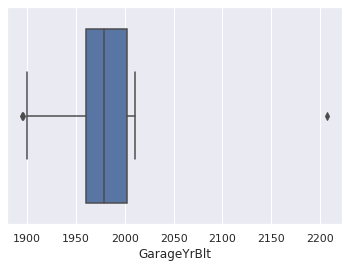

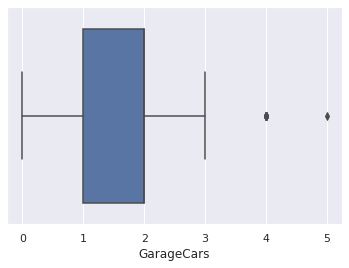

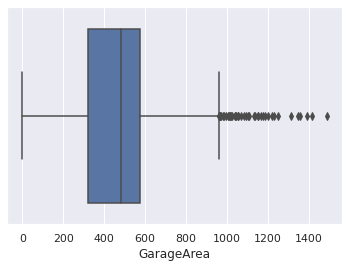

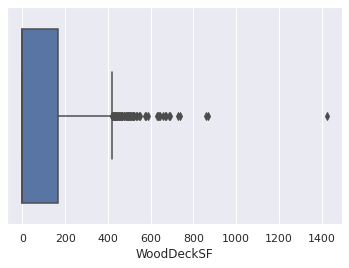

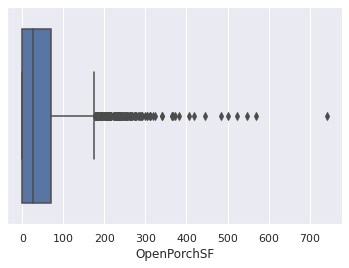

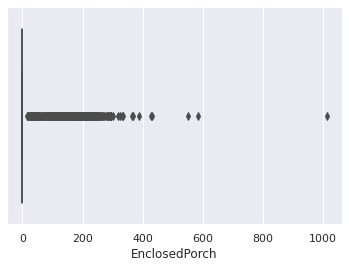

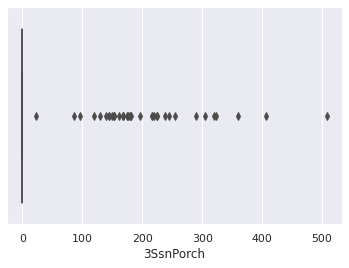

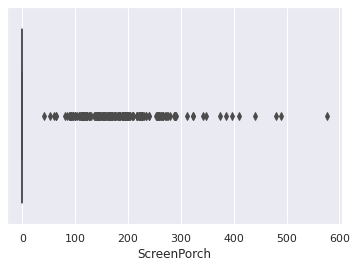

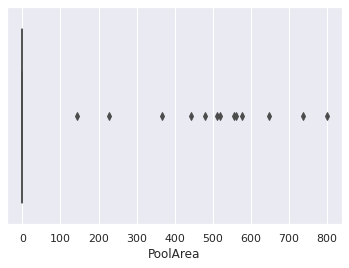

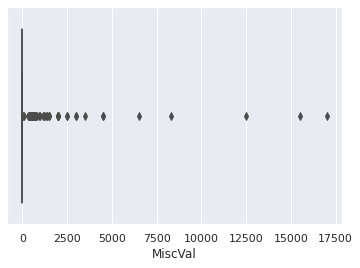

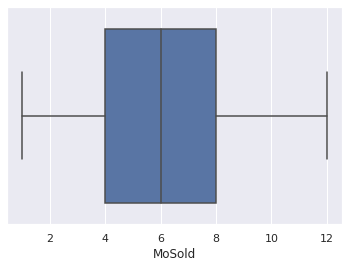

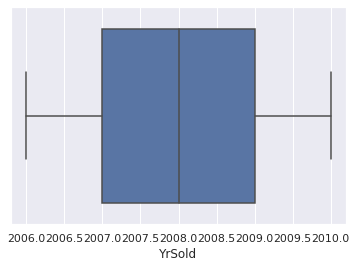

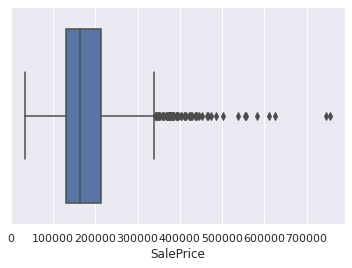

In [18]:
# boxplots to identify outliers
for f in num_columns:
    get_boxplots(f)

Observations:

---

Almost all of our features have an outlier or two. Some of our features do not follow a normal distribution and appear as entirely outliers.<br>
For example: An obvious feature to see an outlier is in KitchenAvbGr. Most would expect that homes have a kitchen on the ground floor. A home with 0, 2 or 3 kitchens on the ground floor has been flagged as an outlier.<br><br>
**Here's the thing about Kaggle and combining our test and training data, though:**<br> You can't remove outlier rows from the testing data or your Kaggle submission won't work. So we can either remove outlier values from the training data after the split or just be aware that they exist.

<h3>3. Investigate at least three potential predictors of the dependent variable and provide appropriate graphs / statistics to demonstrate the relationships.</h3>

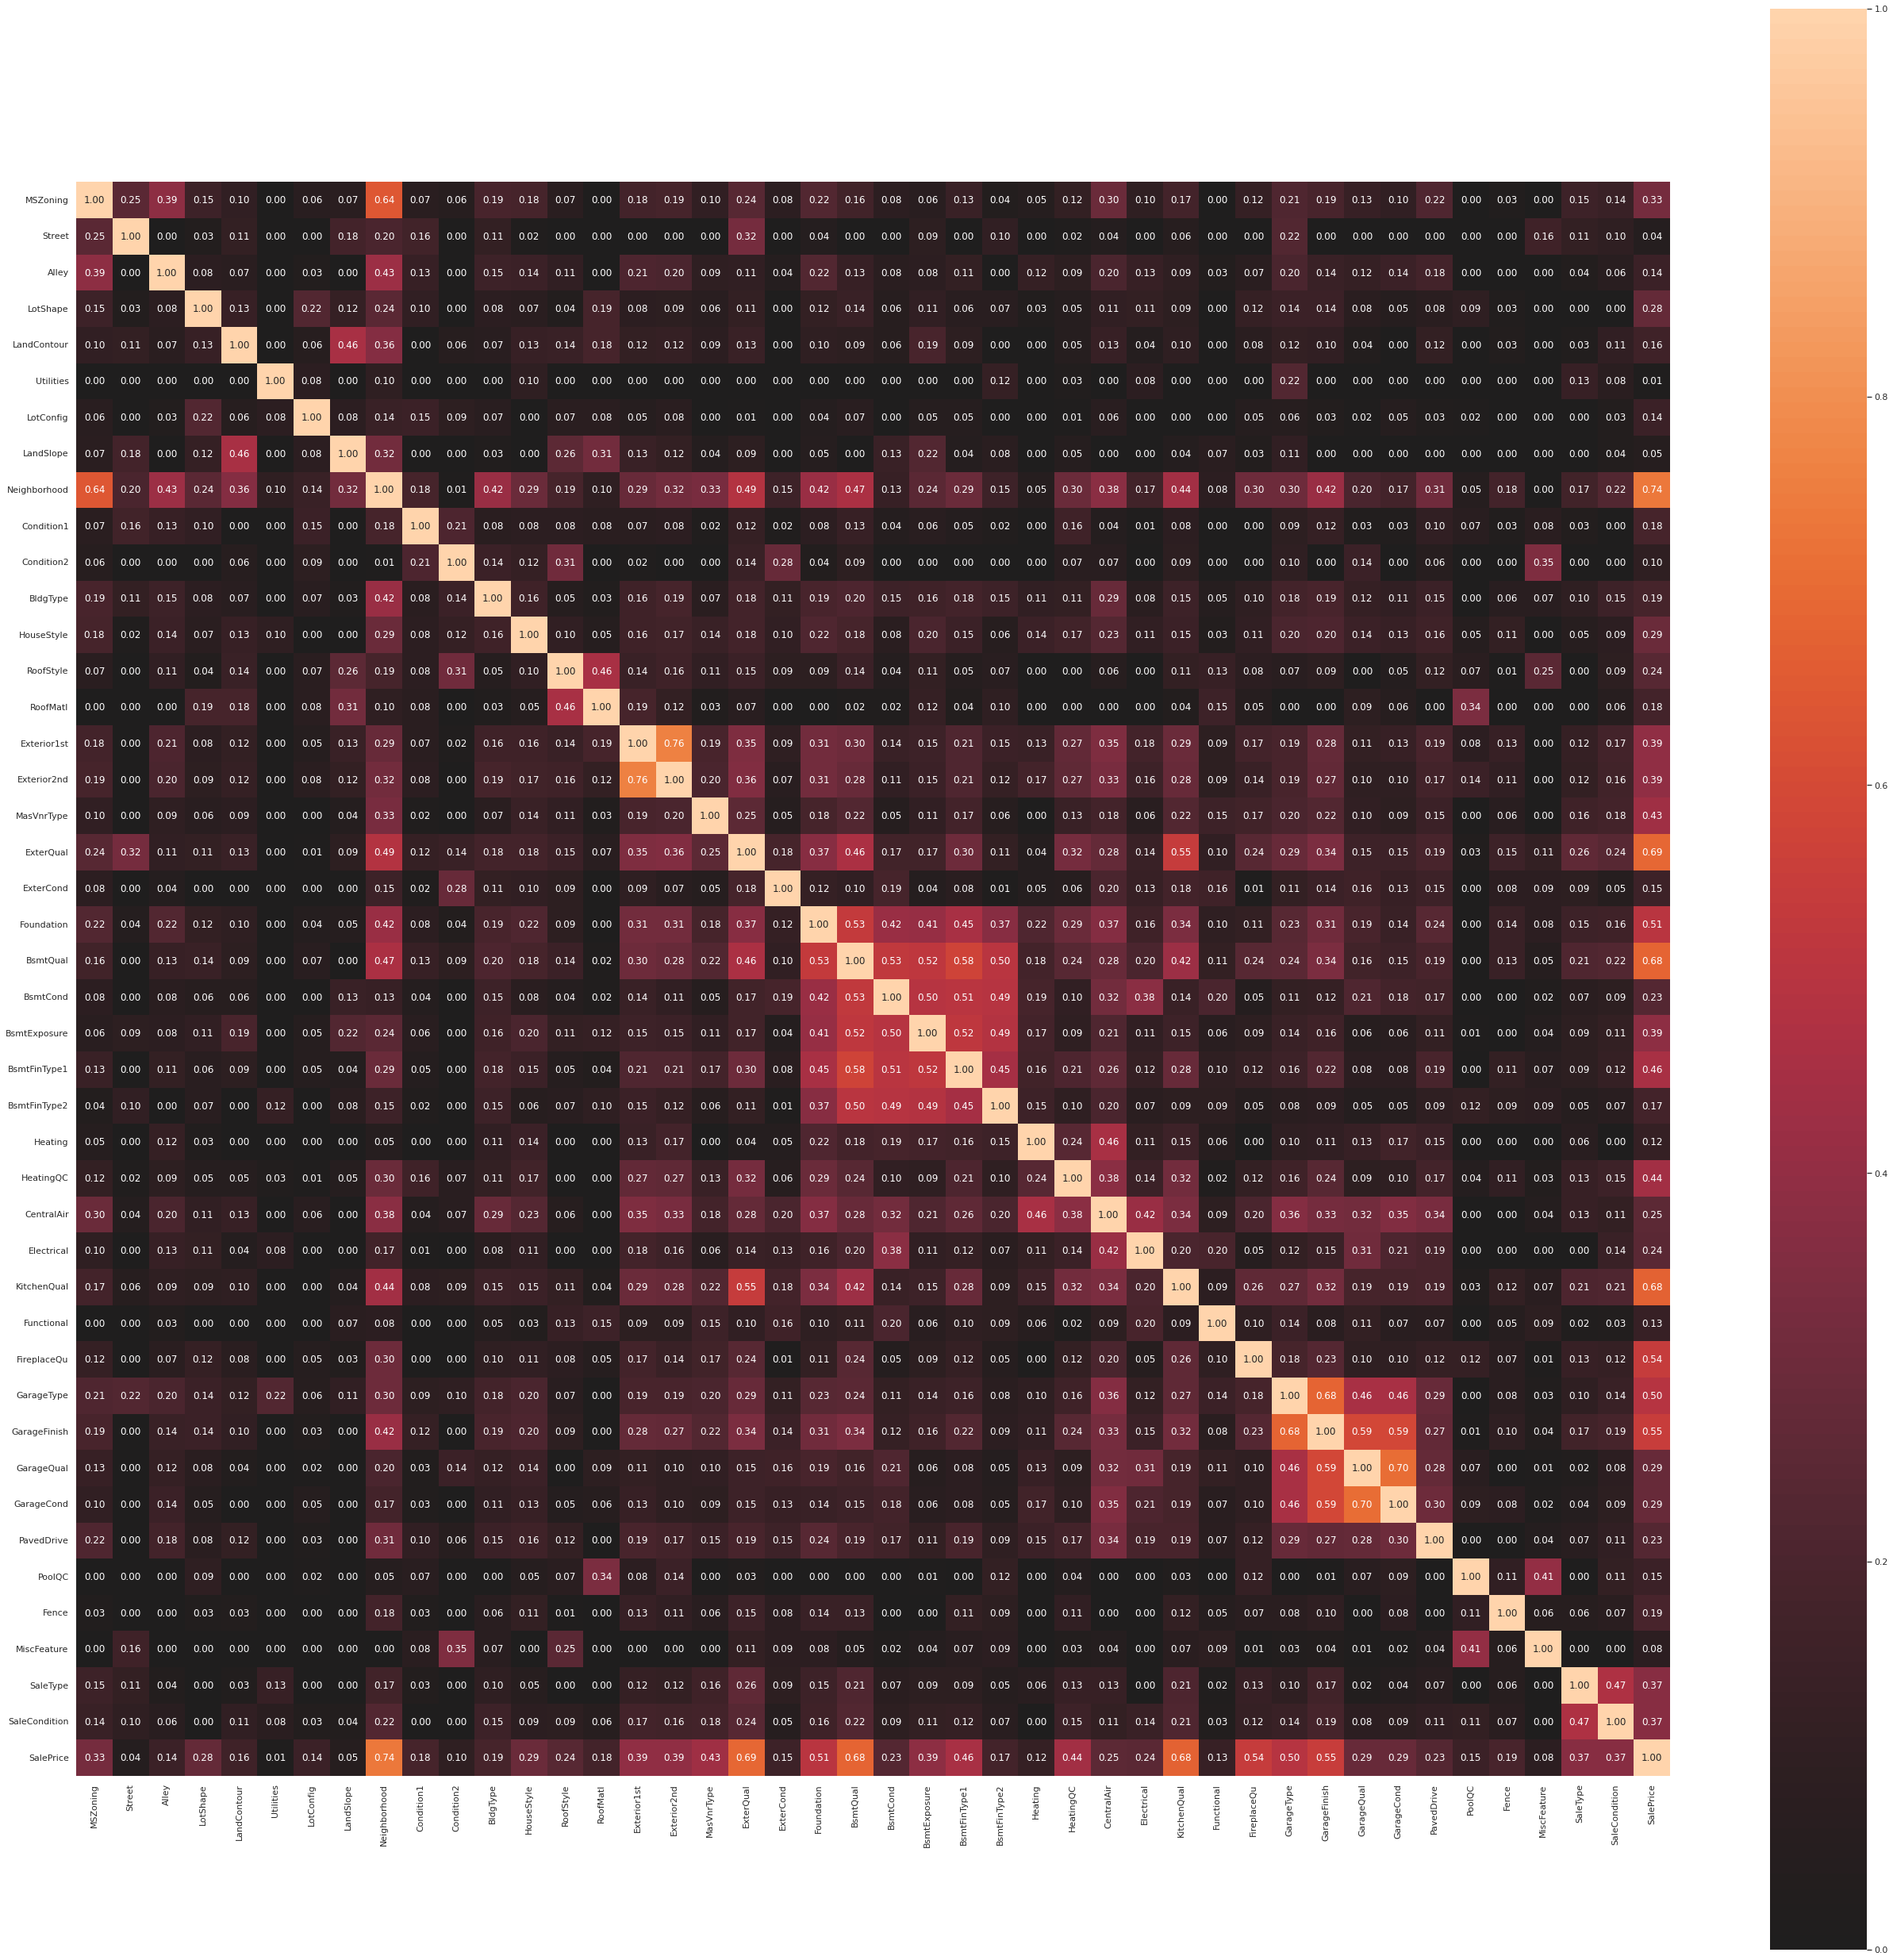

In [19]:
# http://shakedzy.xyz/dython/getting_started/examples/
assoc = associations(df_cat, figsize=(45,45))
# note that df_cat is created from df_training_orig because we're looking for
# correlations with SalePrice and the testing data doesn't have that

Observations:<br>
Features with > 50% positive correlation to our dependent variable SalesPrice:<br>
Neighborhood<br>
ExterQual<br>
Foundation<br>
BsmtQual<br>
FireplaceQu<br>
GarageType<br>
GarageFinish<br>


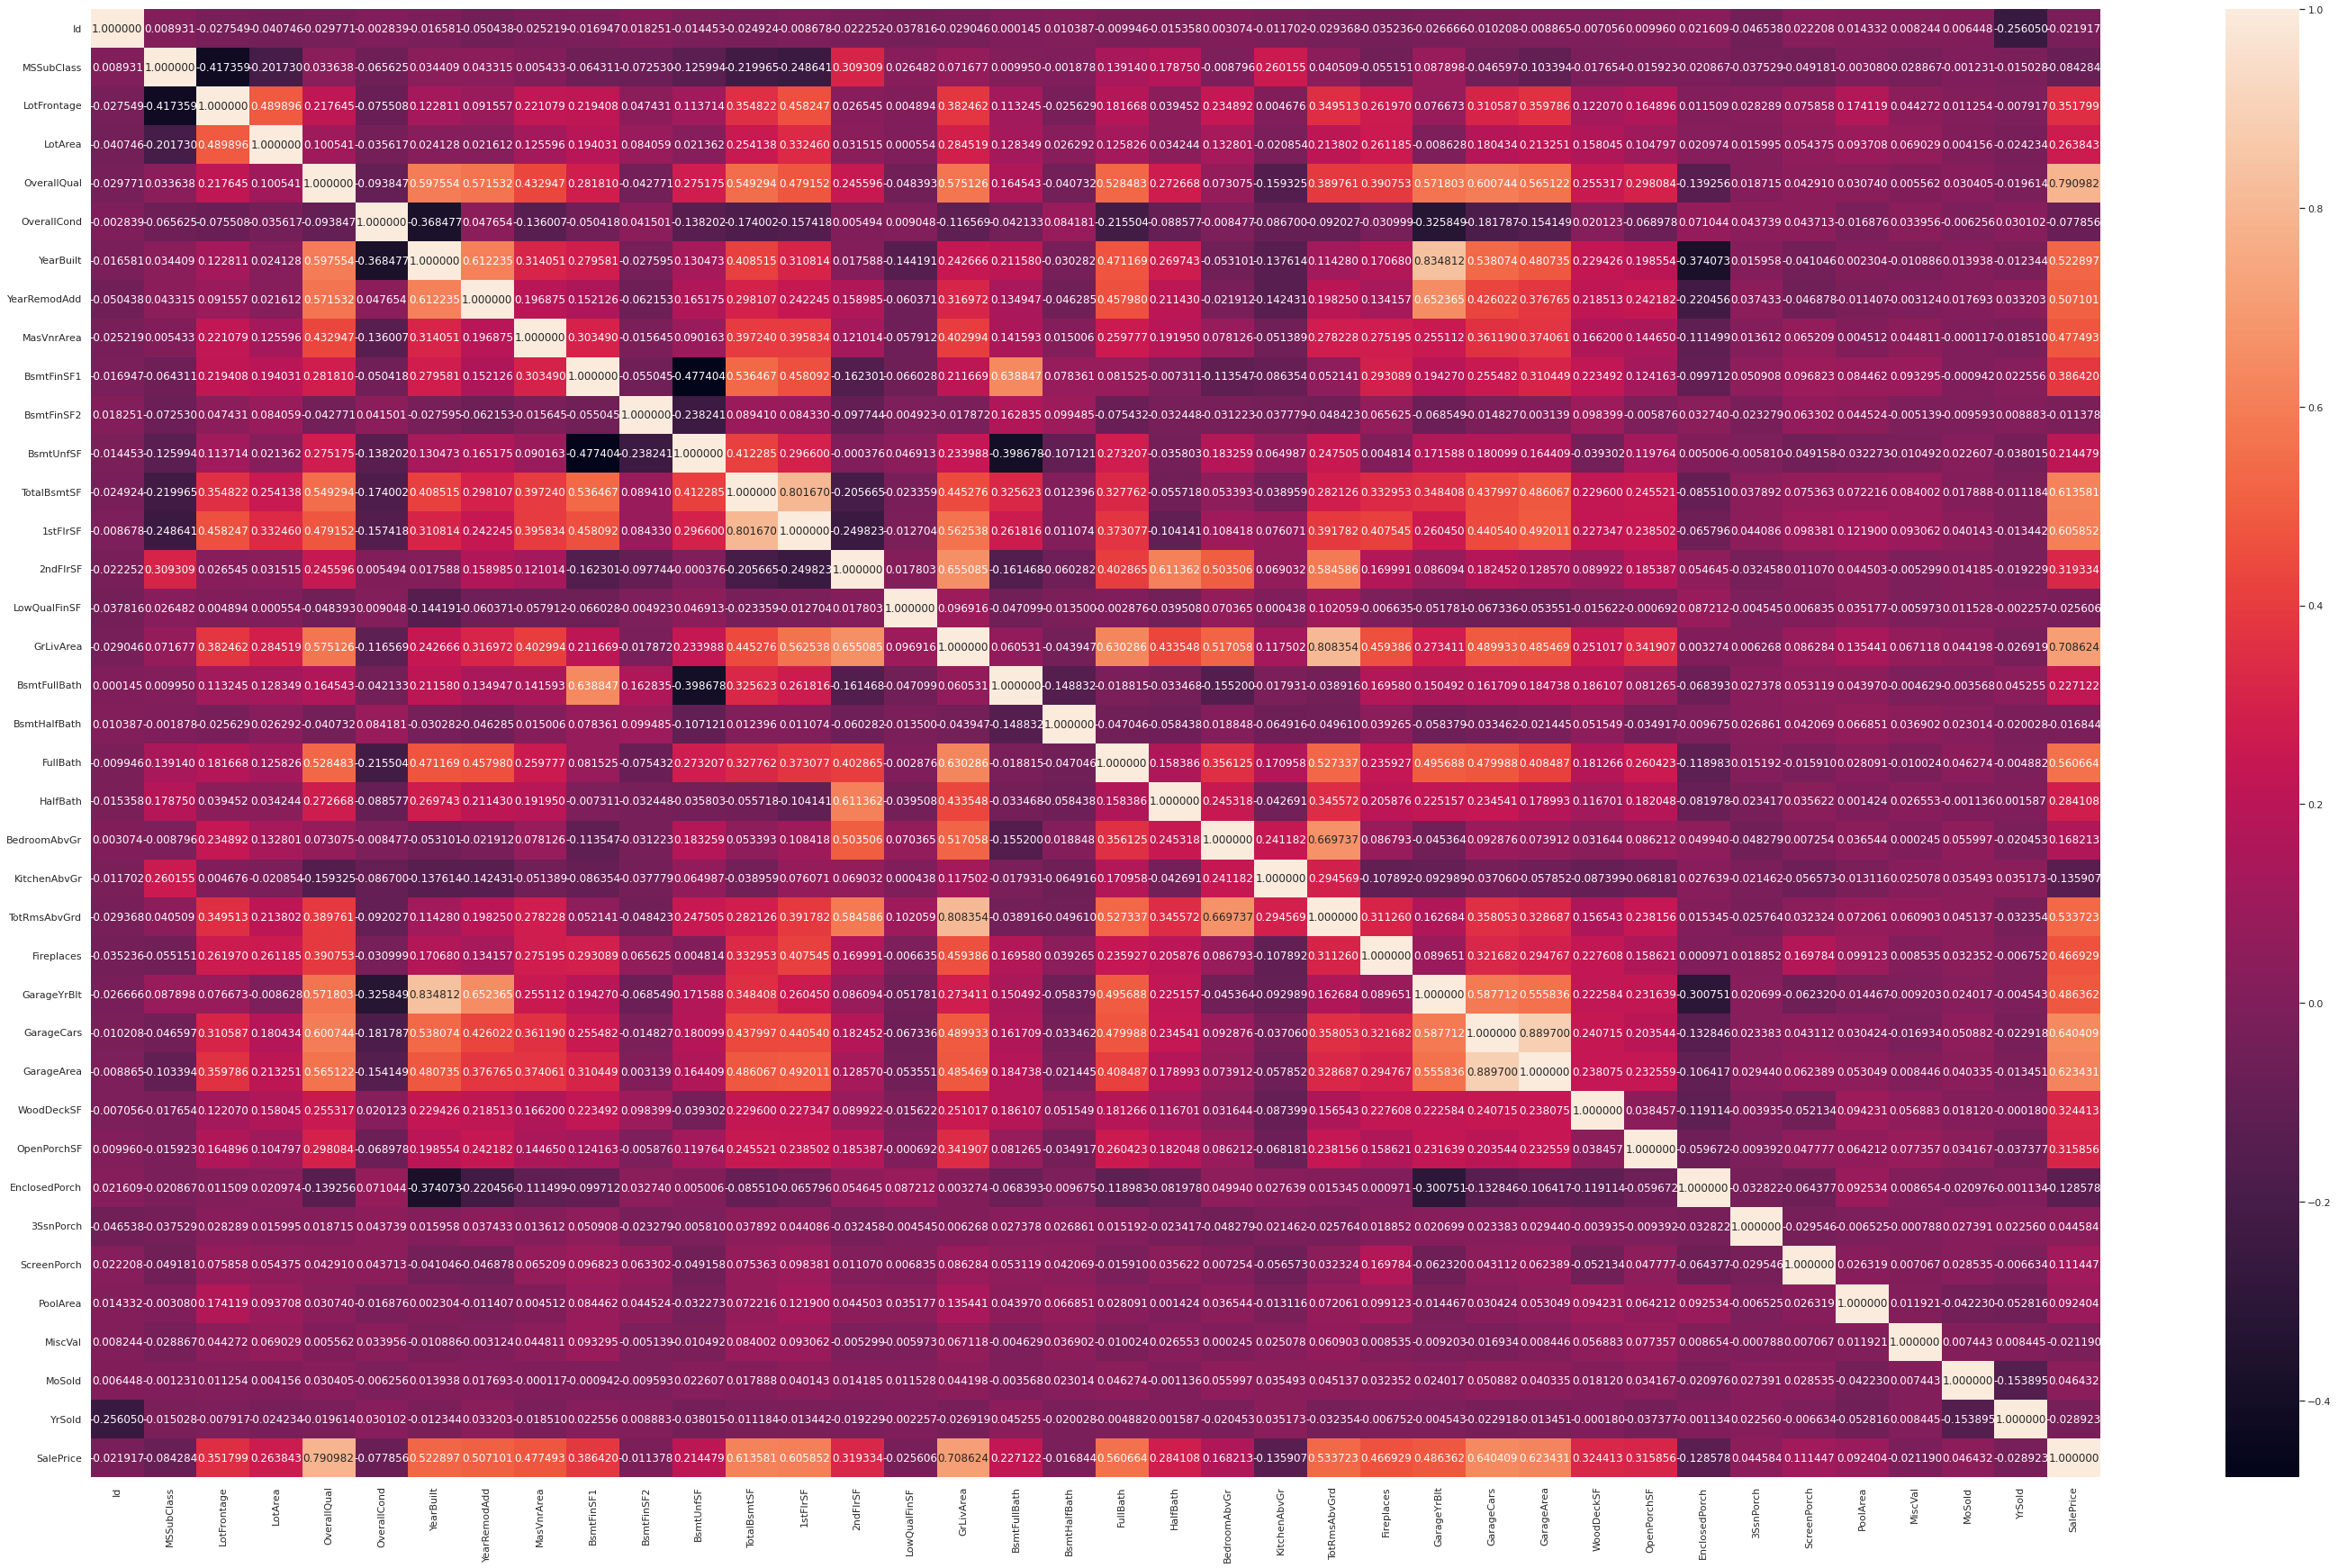

In [20]:
# credit: https://www.kaggle.com/gorkembakir/hp-eda
f, ax =plt.subplots(figsize=(50,30))
sns.heatmap(df.corr(),annot=True, fmt="1f", ax=ax)
plt.show()

<span style="color:blue">Observations:</span><br>
<strong>Features with > 50% positive correlation to our dependent variable SalesPrice:</strong><br>
OverallQual<br>
YearBuilt<br>
YearRemodAdd<br>
TotalBsmtSF<br>
1stFlSF<br>
GrLivArea<br>
FullBath<br>
TotRmsAbvGrd<br>
GarageCars<br>
GarageArea<br>
<br>
This also shows that some of our features are stongly correlated to each other, such as:<br>
OverallQual and GarageCars <br>
OverallQual and YearBuilt<br>
GarageYrBlt and YearBuilt<br>
TotRmsAbvGrd and GrLivArea<br>
GarageArea and GarageCars<br>


<h4>Potential Predictor of the dependent variable (SalePrice) #1: OverallQual</h4>

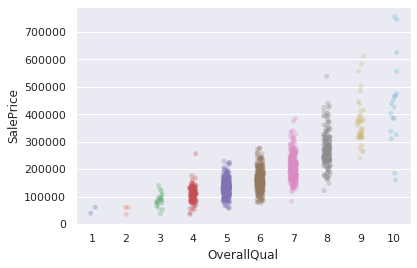

In [21]:
sns.stripplot(x='OverallQual', y='SalePrice', data=df_train_orig, alpha=0.3, jitter=True);

<span style="color:blue">Observations:</span><br>
This appears to confirm that as overall quality increase, so does sale price.

In [22]:
oq=df_train_orig[["OverallQual","SalePrice"]].groupby(["OverallQual"], as_index=False).count().sort_values(by="SalePrice",ascending="True")
oq

OverallQual  SalePrice
0            1          2
1            2          3
9           10         18
2            3         20
8            9         43
3            4        116
7            8        168
6            7        319
5            6        374
4            5        397

This shows us counts associated with each overall quality score.

In [23]:
oq2=df_train_orig[["OverallQual","SalePrice"]].groupby(["OverallQual"], as_index=False).mean().sort_values(by="SalePrice",ascending="True")
oq2

OverallQual      SalePrice
0            1   50150.000000
1            2   51770.333333
2            3   87473.750000
3            4  108420.655172
4            5  133523.347607
5            6  161603.034759
6            7  207716.423197
7            8  274735.535714
8            9  367513.023256
9           10  438588.388889

<span style="color:blue">Observations:</span><br>
This supports the idea that as sales price increases, so does quality score.

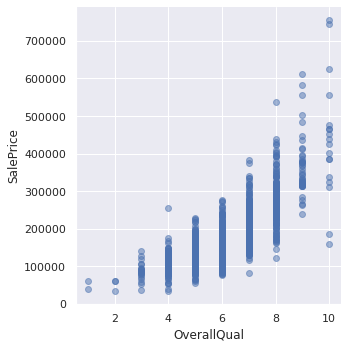

In [24]:
sns.lmplot(x='OverallQual', y='SalePrice', data=df_train_orig, fit_reg=False, scatter_kws={'alpha':0.5});

<h4>Potential Predictor of the dependent variable (SalePrice) #2: YearRemodAdd</h4>

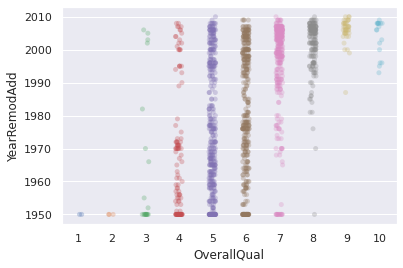

In [25]:
sns.stripplot(x='OverallQual', y='YearRemodAdd', data=df_train_orig, alpha=0.3, jitter=True);

In [26]:
yra2=df_train_orig[["YearRemodAdd","SalePrice"]].groupby(["YearRemodAdd"], as_index=False).mean().sort_values(by="SalePrice",ascending="True")
yra2

YearRemodAdd      SalePrice
2           1952  110398.600000
0           1950  117463.056180
21          1971  120230.555556
4           1954  121142.857143
32          1982  121271.428571
..           ...            ...
57          2007  224807.250000
56          2006  229471.134021
58          2008  269709.100000
59          2009  284085.391304
60          2010  336963.500000

[61 rows x 2 columns]

<span style="color:blue">Observations:</span><br>
This supports the idea that the more recently remodeled homes are selling for higher prices.

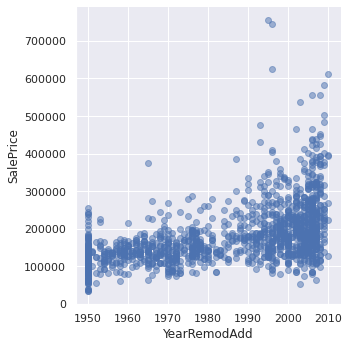

In [27]:
sns.lmplot(x='YearRemodAdd', y='SalePrice', data=df_train_orig, fit_reg=False, scatter_kws={'alpha':0.5});

<span style="color:blue">Observations:</span><br>
It's not super strong, but it does look like there is increased density around the later years and only later years have very high sale prices.

<h4>Potential Predictor of the dependent variable (SalePrice) #2: GarageArea</h4>

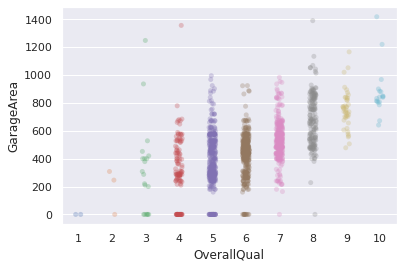

In [28]:
sns.stripplot(x='OverallQual', y='GarageArea', data=df_train_orig, alpha=0.3, jitter=True);

<span style="color:blue">Observations:</span><br>
This one is not as highly correlated. This says that garage area is not the only determining factor of a higher sales price.

In [29]:
ga=df_train_orig[["GarageArea","SalePrice"]].groupby(["GarageArea"], as_index=False).mean().sort_values(by="SalePrice",ascending="True")
ga

GarageArea  SalePrice
75          350    60000.0
42          287    72500.0
5           189    78000.0
8           200    79125.0
437        1248    81000.0
..          ...        ...
325         716   556581.0
428        1020   582933.0
364         807   625000.0
368         813   745000.0
377         832   755000.0

[441 rows x 2 columns]

<span style="color:blue">Observations:</span><br>
Again, some home with smaller garages are selling for a higher price, supporting the idea that garage size alone is not a predictor of sale price.

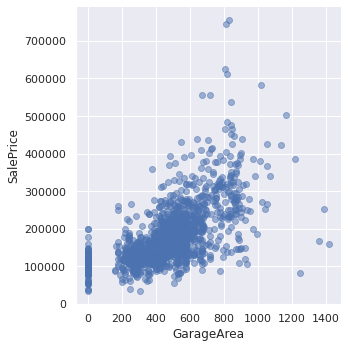

In [30]:
sns.lmplot(x='GarageArea', y='SalePrice', data=df_train_orig, fit_reg=False, scatter_kws={'alpha':0.5});

<span style="color:blue">Observations:</span><br>
There must be another factor that would cause this feature to correlate better with sale price. 

<h3>4. Engage in feature creation by splitting, merging, or otherwise generating a new predictor.</h3>

Create a feature that indicates if the home has a garage or not.

In [31]:
for index, row in enumerate(df_train_orig["GarageType"]):
    #print(row)
    if pd.isna(row):
        df.loc[index, "HasGarage"] = "Yes"
    else:
        df.loc[index, "HasGarage"] = "No"

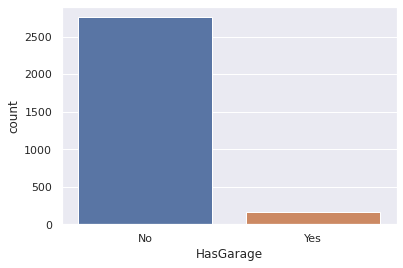

In [32]:
#sns.lmplot(x='HasGarage', y='SalePrice', data=df_train, fit_reg=False, scatter_kws={'alpha':0.5});
sns.countplot(x='HasGarage', data=df);

Did a little check-see to ensure we have some of each value coming through.

<h3>5. Using the dependent variable, perform both min-max and standard scaling in Python.</h3>

<h4>min-max</h4>

                0            1   ...           36           37
count  2919.000000  2919.000000  ...  2919.000000  1460.000000
mean      0.500000     0.218457  ...     0.448184     0.202779
std       0.288824     0.250104  ...     0.328741     0.110321
min       0.000000     0.000000  ...     0.000000     0.000000
25%       0.250000     0.000000  ...     0.250000     0.132030
50%       0.500000     0.176471  ...     0.500000     0.177892
75%       0.750000     0.294118  ...     0.750000     0.248715
max       1.000000     1.000000  ...     1.000000     1.000000

[8 rows x 38 columns]


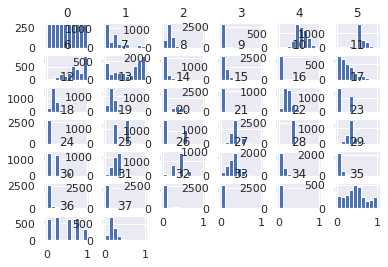

In [33]:
# https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
# retrieve just the numeric input values
data = df.select_dtypes(include=[np.number])
#print(data)
# perform a robust scaler transform of the dataset
trans = MinMaxScaler()
data_trans = trans.fit_transform(data)
# convert the array back to a dataframe
dataset = pd.DataFrame(data_trans)
# summarize
print(dataset.describe())
# histograms of the variables
dataset.hist()
plt.show()

Distributions have been adjusted to between 0 and 1 min-max.

<h4>standard scaling</h4>

                 0             1   ...            36            37
count  2.919000e+03  2.919000e+03  ...  2.919000e+03  1.460000e+03
mean  -1.019321e-17  6.337476e-17  ...  6.165629e-14  1.180182e-16
std    1.000171e+00  1.000171e+00  ...  1.000171e+00  1.000343e+00
min   -1.731458e+00 -8.736160e-01  ... -1.363569e+00 -1.838704e+00
25%   -8.657288e-01 -8.736160e-01  ... -6.029616e-01 -6.415162e-01
50%    0.000000e+00 -1.679054e-01  ...  1.576455e-01 -2.256643e-01
75%    8.657288e-01  3.025683e-01  ...  9.182526e-01  4.165294e-01
max    1.731458e+00  3.125411e+00  ...  1.678860e+00  7.228819e+00

[8 rows x 38 columns]


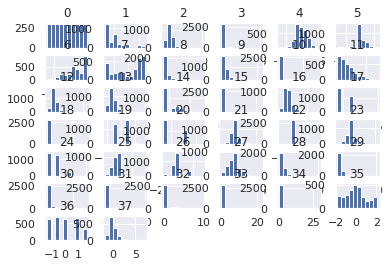

In [34]:
# https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
data = df.select_dtypes(include=[np.number])
#print(data)
# perform a robust scaler transform of the dataset
trans = StandardScaler()
data_trans = trans.fit_transform(data)
# convert the array back to a dataframe
dataset = pd.DataFrame(data_trans)
# summarize
print(dataset.describe())
# histograms of the variables
dataset.hist()
plt.show()

Distributions have been adjusted and the mean is a very small number close to zero and the standard deviation is very close to 1.0 for each variable.

## Feature Reduction

In [35]:
#sns.pairplot(df_train_orig)

<h3>Remove insignificant features with < .5 correlation with SalesPrice</h3>

In [36]:
corr_matrix = df_train_orig.corr()
corr_matrix

Id  MSSubClass  LotFrontage  ...    MoSold    YrSold  SalePrice
Id             1.000000    0.011156    -0.010601  ...  0.021172  0.000712  -0.021917
MSSubClass     0.011156    1.000000    -0.386347  ... -0.013585 -0.021407  -0.084284
LotFrontage   -0.010601   -0.386347     1.000000  ...  0.011200  0.007450   0.351799
LotArea       -0.033226   -0.139781     0.426095  ...  0.001205 -0.014261   0.263843
OverallQual   -0.028365    0.032628     0.251646  ...  0.070815 -0.027347   0.790982
OverallCond    0.012609   -0.059316    -0.059213  ... -0.003511  0.043950  -0.077856
YearBuilt     -0.012713    0.027850     0.123349  ...  0.012398 -0.013618   0.522897
YearRemodAdd  -0.021998    0.040581     0.088866  ...  0.021490  0.035743   0.507101
MasVnrArea    -0.050298    0.022936     0.193458  ... -0.005965 -0.008201   0.477493
BsmtFinSF1    -0.005024   -0.069836     0.233633  ... -0.015727  0.014359   0.386420
BsmtFinSF2    -0.005968   -0.065649     0.049900  ... -0.015211  0.031706  -0.011378
BsmtUnfSF     -0.007940   -0.140759     0.132644  ...  0.034888 -0.041258   0.214479
TotalBsmtSF   -0.015415   -0.238518     0.392075  ...  0.013196 -0.014969   0.613581
1stFlrSF       0.010496   -0.251758     0.457181  ...  0.031372 -0.013604   0.605852
2ndFlrSF       0.005590    0.307886     0.080177  ...  0.035164 -0.028700   0.319334
LowQualFinSF  -0.044230    0.046474     0.038469  ... -0.022174 -0.028921  -0.025606
GrLivArea      0.008273    0.074853     0.402797  ...  0.050240 -0.036526   0.708624
BsmtFullBath   0.002289    0.003491     0.100949  ... -0.025361  0.067049   0.227122
BsmtHalfBath  -0.020155   -0.002333    -0.007234  ...  0.032873 -0.046524  -0.016844
FullBath       0.005587    0.131608     0.198769  ...  0.055872 -0.019669   0.560664
HalfBath       0.006784    0.177354     0.053532  ... -0.009050 -0.010269   0.284108
BedroomAbvGr   0.037719   -0.023438     0.263170  ...  0.046544 -0.036014   0.168213
KitchenAbvGr   0.002951    0.281721    -0.006069  ...  0.026589  0.031687  -0.135907
TotRmsAbvGrd   0.027239    0.040380     0.352096  ...  0.036907 -0.034516   0.533723
Fireplaces    -0.019772   -0.045569     0.266639  ...  0.046357 -0.024096   0.466929
GarageYrBlt    0.000072    0.085072     0.070250  ...  0.005337 -0.001014   0.486362
GarageCars     0.016570   -0.040110     0.285691  ...  0.040522 -0.039117   0.640409
GarageArea     0.017634   -0.098672     0.344997  ...  0.027974 -0.027378   0.623431
WoodDeckSF    -0.029643   -0.012579     0.088521  ...  0.021011  0.022270   0.324413
OpenPorchSF   -0.000477   -0.006100     0.151972  ...  0.071255 -0.057619   0.315856
EnclosedPorch  0.002889   -0.012037     0.010700  ... -0.028887 -0.009916  -0.128578
3SsnPorch     -0.046635   -0.043825     0.070029  ...  0.029474  0.018645   0.044584
ScreenPorch    0.001330   -0.026030     0.041383  ...  0.023217  0.010694   0.111447
PoolArea       0.057044    0.008283     0.206167  ... -0.033737 -0.059689   0.092404
MiscVal       -0.006242   -0.007683     0.003368  ... -0.006495  0.004906  -0.021190
MoSold         0.021172   -0.013585     0.011200  ...  1.000000 -0.145721   0.046432
YrSold         0.000712   -0.021407     0.007450  ... -0.145721  1.000000  -0.028923
SalePrice     -0.021917   -0.084284     0.351799  ...  0.046432 -0.028923   1.000000

[38 rows x 38 columns]

In [37]:
# https://www.kaggle.com/omkaarp/house-prices-regression-techniques-submission
corr_matrix['SalePrice'][(corr_matrix["SalePrice"] > 0.50) | (corr_matrix["SalePrice"] < -0.50)]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

Categorical Features

In [38]:
cat_corr = assoc['corr']
cat_corr, _ = cluster_correlations(cat_corr)
print(cat_corr)

               SalePrice  Neighborhood  ...  Electrical   Heating
SalePrice       1.000000      0.738630  ...    0.244318  0.120155
Neighborhood    0.738630      1.000000  ...    0.166131  0.053761
KitchenQual     0.675721      0.444320  ...    0.200720  0.154696
Foundation      0.506328      0.417266  ...    0.161071  0.216288
ExterQual       0.690933      0.485240  ...    0.136463  0.042444
BsmtQual        0.681905      0.465577  ...    0.198460  0.178650
LotConfig       0.144981      0.136832  ...    0.000000  0.000000
LotShape        0.276362      0.244025  ...    0.109916  0.025132
LandContour     0.160605      0.359864  ...    0.044845  0.000000
LandSlope       0.051784      0.315128  ...    0.000000  0.000000
RoofMatl        0.177237      0.095337  ...    0.000000  0.000000
RoofStyle       0.240201      0.186214  ...    0.000000  0.000000
PoolQC          0.145588      0.051315  ...    0.000000  0.000000
MiscFeature     0.084141      0.000000  ...    0.000000  0.000000
ExterCond 

In [39]:
cat_corr['SalePrice'][(cat_corr["SalePrice"] > 0.50) | (cat_corr["SalePrice"] < -0.50)]

SalePrice       1.000000
Neighborhood    0.738630
KitchenQual     0.675721
Foundation      0.506328
ExterQual       0.690933
BsmtQual        0.681905
GarageFinish    0.553059
FireplaceQu     0.542181
Name: SalePrice, dtype: float64

In [40]:
significant_cols = list(corr_matrix['SalePrice'][(corr_matrix["SalePrice"] > 0.5) | (corr_matrix["SalePrice"] < -0.5)].index)
#print(significant_cols)
sig_cat_cols = list(cat_corr['SalePrice'][(cat_corr["SalePrice"] > 0.5) | (cat_corr["SalePrice"] < -0.5)].index)
sig_cat_cols.remove('SalePrice')
print(sig_cat_cols)
significant_cols.extend(sig_cat_cols)
#print(significant_cols)

df_sig = df[significant_cols]

significant_cols.remove('SalePrice')
print(f'Number of significant features: {len(significant_cols)} \n Those features are: {significant_cols}')

['Neighborhood', 'KitchenQual', 'Foundation', 'ExterQual', 'BsmtQual', 'GarageFinish', 'FireplaceQu']
Number of significant features: 17 
 Those features are: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'Neighborhood', 'KitchenQual', 'Foundation', 'ExterQual', 'BsmtQual', 'GarageFinish', 'FireplaceQu']


In [41]:
df_sig.shape

(2919, 18)

Correlation of our significant features to each other

Visualize the relationship between the significant independent variables and our dependent variable (SalePrice) as well as correlation with each other

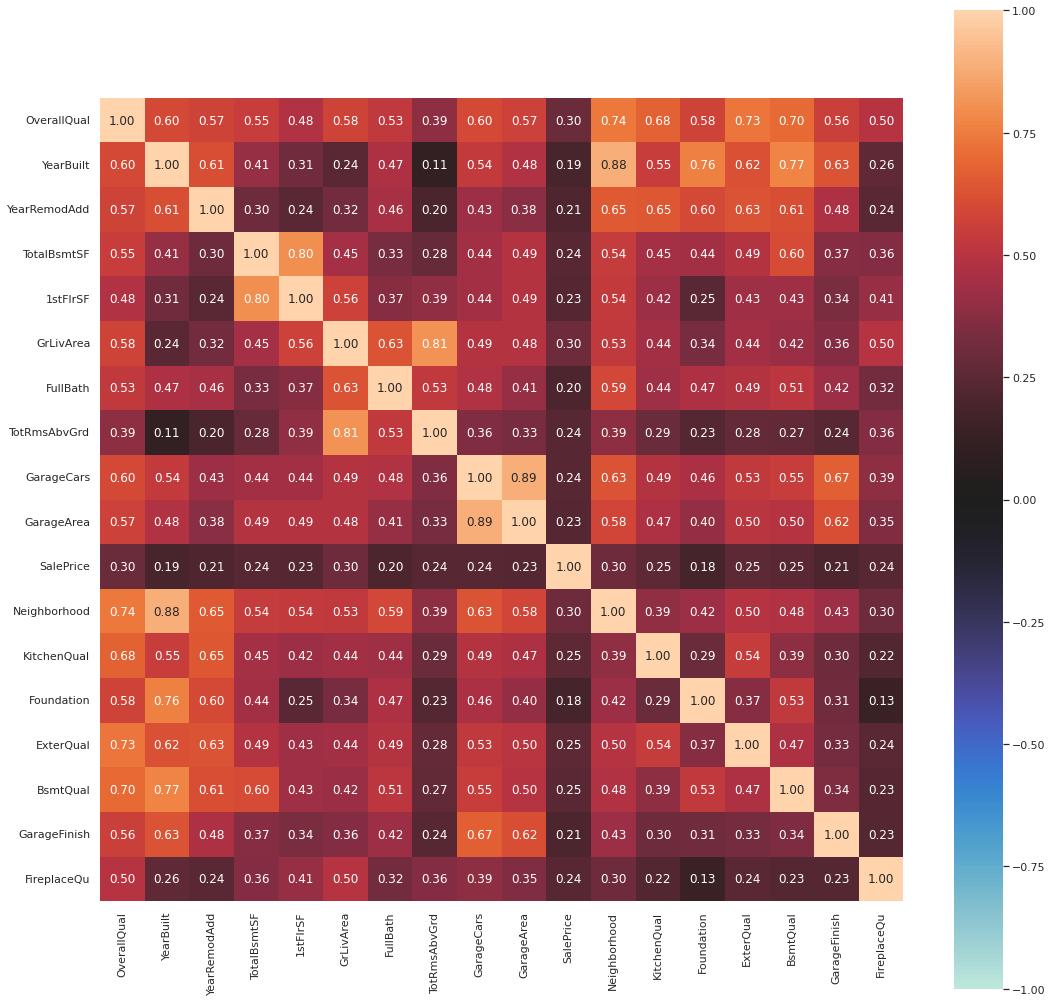

In [42]:
assoc2 = associations(df_sig, figsize=(18,18))

Features that are highly correlated to another feature:<br>
YearBuilt - OverallQual, YearRemodAdd, GarageCars, Neighborhood, Foundation, BsmtQual, GarageFinish<br>
YearRemodAdd - OverallQual, YearBuilt, Neighborhood, KitchenQual, Foundation,ExterQual, BsmtQual<br>
TotalBsmtSF - OverallQual, 1stFlrSF,  Neighborhood, BsmtQual<br>
1stFlrSF - TotalBsmtSF, GrLivArea, Neighborhood<br>
GrLivArea - OverallQual, 2stFlrSF, FullBath, TotRmsAbvGrd, Neighborhood<br>
FullBath - OverallQual, TotRmsAbvGrd, Neighborhood, BsmtQual<br>
TotRmsAbvGrd - GrLivArea<br>
GarageCars - OverallQual, YearBuilt, GarageArea, Neighborhood, ExterQual,BsmtQual, GarageFinish<br>
GarageArea - OverallQual, GarageCars, Neighborhood, ExterQual, BsmtQual, GarageFinish<br>
Neighborhood - OverallQual,YearBuilt,TotalBsmtSF, 1stFlrSF, GrLivArea, FullBath, GarageCars, GarageArea, ExterQual<br>
KitchQual - OverallQual, YearBuilt, YearRemodAdd, ExterQual<br>
Foundation - OverallQual, YearBuilt, YearRemodAdd, BsmtQual<br>
ExterQual - OverallQual, YearBuilt, YearRemodAdd, GarageCars, GarageArea, Neighborhood, KitchenQual<br>
BsmtQual - OverallQual, YearBuilt, YearRemodAdd, TotalBsmtSF, FullBath, GarageCars, Garage Area, Foundation<br>
GarageFinish - OverallQual, YearBuilt, GarageCars, GarageArea<br>
FireplaceQu - OverallQual, GrLivArea<br>
<br>
Since we don't want our independent variables highly correlated to each other, I want to try models that remove:<br>
OverallQual, 1stFlrSF and TotRmsAbvGrd, Neighborhood<br>
<br>
and models that remove:<br>
YearBuilt, YearRemodAdd, TotalBsmtSF, GrLivArea, FullBath, GarageArea, 1stFlrSF, GarageCars
<br>
<br>idea: add that HasGarage var back in

In [43]:
# create lists of the features I want to use in the models
df_feature_set_1 = ['Id','YearBuilt', 'YearRemodAdd', 'TotalBsmtSF',  'GrLivArea', 'FullBath',  'GarageCars', 'GarageArea', 'KitchenQual', 'Foundation', 'ExterQual', 'BsmtQual', 'GarageFinish', 'FireplaceQu','SalePrice']
df_feature_set_2 = ['Id', 'OverallQual',  'TotRmsAbvGrd',   'Neighborhood', 'KitchenQual', 'Foundation', 'ExterQual', 'BsmtQual', 'GarageFinish', 'FireplaceQu','SalePrice']


In [44]:
# feature set 1
df_fs1 = df[df_feature_set_1]
# feature set 2
df_fs2 = df[df_feature_set_2]

In [45]:
df_fs1.head()

Id  YearBuilt  YearRemodAdd  ...  GarageFinish  FireplaceQu  SalePrice
0   1       2003          2003  ...           RFn          NaN   208500.0
1   2       1976          1976  ...           RFn           TA   181500.0
2   3       2001          2002  ...           RFn           TA   223500.0
3   4       1915          1970  ...           Unf           Gd   140000.0
4   5       2000          2000  ...           RFn           TA   250000.0

[5 rows x 15 columns]

In [46]:
df_fs1.describe()

Id    YearBuilt  ...   GarageArea      SalePrice
count  2919.000000  2919.000000  ...  2918.000000    1460.000000
mean   1460.000000  1971.312778  ...   472.874572  180921.195890
std     842.787043    30.291442  ...   215.394815   79442.502883
min       1.000000  1872.000000  ...     0.000000   34900.000000
25%     730.500000  1953.500000  ...   320.000000  129975.000000
50%    1460.000000  1973.000000  ...   480.000000  163000.000000
75%    2189.500000  2001.000000  ...   576.000000  214000.000000
max    2919.000000  2010.000000  ...  1488.000000  755000.000000

[8 rows x 9 columns]

In [47]:
df_fs2.head()

Id  OverallQual  TotRmsAbvGrd  ... GarageFinish FireplaceQu SalePrice
0   1            7             8  ...          RFn         NaN  208500.0
1   2            6             6  ...          RFn          TA  181500.0
2   3            7             6  ...          RFn          TA  223500.0
3   4            7             7  ...          Unf          Gd  140000.0
4   5            8             9  ...          RFn          TA  250000.0

[5 rows x 11 columns]

In [48]:
df_fs2.describe()

Id  OverallQual  TotRmsAbvGrd      SalePrice
count  2919.000000  2919.000000   2919.000000    1460.000000
mean   1460.000000     6.089072      6.451524  180921.195890
std     842.787043     1.409947      1.569379   79442.502883
min       1.000000     1.000000      2.000000   34900.000000
25%     730.500000     5.000000      5.000000  129975.000000
50%    1460.000000     6.000000      6.000000  163000.000000
75%    2189.500000     7.000000      7.000000  214000.000000
max    2919.000000    10.000000     15.000000  755000.000000

## Preprocessing - Imputing and Scaling the data

Encode our categorical variables

In [49]:
df.describe()

Id   MSSubClass  ...       YrSold      SalePrice
count  2919.000000  2919.000000  ...  2919.000000    1460.000000
mean   1460.000000    57.137718  ...  2007.792737  180921.195890
std     842.787043    42.517628  ...     1.314964   79442.502883
min       1.000000    20.000000  ...  2006.000000   34900.000000
25%     730.500000    20.000000  ...  2007.000000  129975.000000
50%    1460.000000    50.000000  ...  2008.000000  163000.000000
75%    2189.500000    70.000000  ...  2009.000000  214000.000000
max    2919.000000   190.000000  ...  2010.000000  755000.000000

[8 rows x 38 columns]

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

## Adding Dummy Variables

<h3>Convert Categorical data to numerical</h3>

In [51]:
# feature set 1
fs1_objs = df_fs1.select_dtypes(include=['object']).columns.tolist()
encoded_df_fs1 = pd.get_dummies(df_fs1, prefix='dummy', prefix_sep='_', dummy_na=False, columns=fs1_objs)
# feature set 2
fs2_objs = df_fs2.select_dtypes(include=['object']).columns.tolist()
encoded_df_fs2 = pd.get_dummies(df_fs2, prefix='dummy', prefix_sep='_', dummy_na=False, columns=fs2_objs)

In [52]:
encoded_df_fs1.head()

Id  YearBuilt  YearRemodAdd  ...  dummy_Gd  dummy_Po  dummy_TA
0   1       2003          2003  ...         0         0         0
1   2       1976          1976  ...         0         0         1
2   3       2001          2002  ...         0         0         1
3   4       1915          1970  ...         1         0         0
4   5       2000          2000  ...         0         0         1

[5 rows x 35 columns]

In [53]:
encoded_df_fs2.head()

Id  OverallQual  TotRmsAbvGrd  ...  dummy_Gd  dummy_Po  dummy_TA
0   1            7             8  ...         0         0         0
1   2            6             6  ...         0         0         1
2   3            7             6  ...         0         0         1
3   4            7             7  ...         1         0         0
4   5            8             9  ...         0         0         1

[5 rows x 55 columns]

## <h3>Scaling</h3>

### <h3>Find and Fill in missing Values</h3>

Another check for nulls:

In [54]:
encoded_df_fs1.isna().sum()

Id                 0
YearBuilt          0
YearRemodAdd       0
TotalBsmtSF        1
GrLivArea          0
FullBath           0
GarageCars         1
GarageArea         1
SalePrice       1459
dummy_Ex           0
dummy_Fa           0
dummy_Gd           0
dummy_TA           0
dummy_BrkTil       0
dummy_CBlock       0
dummy_PConc        0
dummy_Slab         0
dummy_Stone        0
dummy_Wood         0
dummy_Ex           0
dummy_Fa           0
dummy_Gd           0
dummy_TA           0
dummy_Ex           0
dummy_Fa           0
dummy_Gd           0
dummy_TA           0
dummy_Fin          0
dummy_RFn          0
dummy_Unf          0
dummy_Ex           0
dummy_Fa           0
dummy_Gd           0
dummy_Po           0
dummy_TA           0
dtype: int64

In [55]:
encoded_df_fs1['TotalBsmtSF'] = encoded_df_fs1['TotalBsmtSF'].fillna(0)
encoded_df_fs1['GarageCars'] = encoded_df_fs1['GarageCars'].fillna(0)
encoded_df_fs1['GarageArea'] = encoded_df_fs1['GarageArea'].fillna(0)
encoded_df_fs1.isna().sum()

Id                 0
YearBuilt          0
YearRemodAdd       0
TotalBsmtSF        0
GrLivArea          0
FullBath           0
GarageCars         0
GarageArea         0
SalePrice       1459
dummy_Ex           0
dummy_Fa           0
dummy_Gd           0
dummy_TA           0
dummy_BrkTil       0
dummy_CBlock       0
dummy_PConc        0
dummy_Slab         0
dummy_Stone        0
dummy_Wood         0
dummy_Ex           0
dummy_Fa           0
dummy_Gd           0
dummy_TA           0
dummy_Ex           0
dummy_Fa           0
dummy_Gd           0
dummy_TA           0
dummy_Fin          0
dummy_RFn          0
dummy_Unf          0
dummy_Ex           0
dummy_Fa           0
dummy_Gd           0
dummy_Po           0
dummy_TA           0
dtype: int64

In [56]:
encoded_df_fs2.isna().sum()

Id                  0
OverallQual         0
TotRmsAbvGrd        0
SalePrice        1459
dummy_Blmngtn       0
dummy_Blueste       0
dummy_BrDale        0
dummy_BrkSide       0
dummy_ClearCr       0
dummy_CollgCr       0
dummy_Crawfor       0
dummy_Edwards       0
dummy_Gilbert       0
dummy_IDOTRR        0
dummy_MeadowV       0
dummy_Mitchel       0
dummy_NAmes         0
dummy_NPkVill       0
dummy_NWAmes        0
dummy_NoRidge       0
dummy_NridgHt       0
dummy_OldTown       0
dummy_SWISU         0
dummy_Sawyer        0
dummy_SawyerW       0
dummy_Somerst       0
dummy_StoneBr       0
dummy_Timber        0
dummy_Veenker       0
dummy_Ex            0
dummy_Fa            0
dummy_Gd            0
dummy_TA            0
dummy_BrkTil        0
dummy_CBlock        0
dummy_PConc         0
dummy_Slab          0
dummy_Stone         0
dummy_Wood          0
dummy_Ex            0
dummy_Fa            0
dummy_Gd            0
dummy_TA            0
dummy_Ex            0
dummy_Fa            0
dummy_Gd  

In [57]:
objs = encoded_df_fs1.select_dtypes(include=['object']).columns.tolist()
encoded_df_fs1 = encoded_df_fs1.drop(columns=objs, axis=1)
print(encoded_df_fs1.select_dtypes(include=['float64']).columns.tolist())

['TotalBsmtSF', 'GarageCars', 'GarageArea', 'SalePrice']


In [58]:
objs = encoded_df_fs2.select_dtypes(include=['object']).columns.tolist()
encoded_df_fs2 = encoded_df_fs2.drop(columns=objs, axis=1)
print(encoded_df_fs2.select_dtypes(include=['float64']).columns.tolist())

['SalePrice']


In [59]:
# floats = encoded_df_fs1.select_dtypes(include=['float64']).columns.tolist()
# print(floats)
# for f in floats:
#   encoded_df_fs1[f] = encoded_df_fs1[f].astype(int)

In [60]:
encoded_df_fs1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            2919 non-null   int64  
 1   YearBuilt     2919 non-null   int64  
 2   YearRemodAdd  2919 non-null   int64  
 3   TotalBsmtSF   2919 non-null   float64
 4   GrLivArea     2919 non-null   int64  
 5   FullBath      2919 non-null   int64  
 6   GarageCars    2919 non-null   float64
 7   GarageArea    2919 non-null   float64
 8   SalePrice     1460 non-null   float64
 9   dummy_Ex      2919 non-null   uint8  
 10  dummy_Fa      2919 non-null   uint8  
 11  dummy_Gd      2919 non-null   uint8  
 12  dummy_TA      2919 non-null   uint8  
 13  dummy_BrkTil  2919 non-null   uint8  
 14  dummy_CBlock  2919 non-null   uint8  
 15  dummy_PConc   2919 non-null   uint8  
 16  dummy_Slab    2919 non-null   uint8  
 17  dummy_Stone   2919 non-null   uint8  
 18  dummy_Wood    2919 non-null 

In [61]:
encoded_df_fs2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   OverallQual    2919 non-null   int64  
 2   TotRmsAbvGrd   2919 non-null   int64  
 3   SalePrice      1460 non-null   float64
 4   dummy_Blmngtn  2919 non-null   uint8  
 5   dummy_Blueste  2919 non-null   uint8  
 6   dummy_BrDale   2919 non-null   uint8  
 7   dummy_BrkSide  2919 non-null   uint8  
 8   dummy_ClearCr  2919 non-null   uint8  
 9   dummy_CollgCr  2919 non-null   uint8  
 10  dummy_Crawfor  2919 non-null   uint8  
 11  dummy_Edwards  2919 non-null   uint8  
 12  dummy_Gilbert  2919 non-null   uint8  
 13  dummy_IDOTRR   2919 non-null   uint8  
 14  dummy_MeadowV  2919 non-null   uint8  
 15  dummy_Mitchel  2919 non-null   uint8  
 16  dummy_NAmes    2919 non-null   uint8  
 17  dummy_NPkVill  2919 non-null   uint8  
 18  dummy_NW

In [62]:
print(df_feature_set_1)
df_feature_set_1_nom = ['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'GarageCars', 'GarageArea']
print(df_feature_set_1_nom)

['Id', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'GarageCars', 'GarageArea', 'KitchenQual', 'Foundation', 'ExterQual', 'BsmtQual', 'GarageFinish', 'FireplaceQu', 'SalePrice']
['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'GarageCars', 'GarageArea']


In [63]:
print(df_feature_set_2)
df_feature_set_2_nom = ['OverallQual', 'TotRmsAbvGrd']
print(df_feature_set_2_nom)

['Id', 'OverallQual', 'TotRmsAbvGrd', 'Neighborhood', 'KitchenQual', 'Foundation', 'ExterQual', 'BsmtQual', 'GarageFinish', 'FireplaceQu', 'SalePrice']
['OverallQual', 'TotRmsAbvGrd']


In [64]:
encoded_df_fs2.head()

Id  OverallQual  TotRmsAbvGrd  ...  dummy_Gd  dummy_Po  dummy_TA
0   1            7             8  ...         0         0         0
1   2            6             6  ...         0         0         1
2   3            7             6  ...         0         0         1
3   4            7             7  ...         1         0         0
4   5            8             9  ...         0         0         1

[5 rows x 55 columns]

In [65]:
# MaxMin Scaling
trans = MinMaxScaler()
encoded_df_fs1[df_feature_set_1_nom] = trans.fit_transform(encoded_df_fs1[df_feature_set_1_nom])
encoded_df_fs1.head()

Id  YearBuilt  YearRemodAdd  ...  dummy_Gd  dummy_Po  dummy_TA
0   1   0.949275      0.883333  ...         0         0         0
1   2   0.753623      0.433333  ...         0         0         1
2   3   0.934783      0.866667  ...         0         0         1
3   4   0.311594      0.333333  ...         1         0         0
4   5   0.927536      0.833333  ...         0         0         1

[5 rows x 35 columns]

In [66]:
# MaxMin Scaling
trans = MinMaxScaler()
encoded_df_fs2[df_feature_set_2_nom] = trans.fit_transform(encoded_df_fs2[df_feature_set_2_nom])

In [67]:
encoded_df_fs2.head()

Id  OverallQual  TotRmsAbvGrd  ...  dummy_Gd  dummy_Po  dummy_TA
0   1     0.666667      0.461538  ...         0         0         0
1   2     0.555556      0.307692  ...         0         0         1
2   3     0.666667      0.307692  ...         0         0         1
3   4     0.666667      0.384615  ...         1         0         0
4   5     0.777778      0.538462  ...         0         0         1

[5 rows x 55 columns]

## Return our data to a set of training data and a set of test data (that Kaggle will expect)

In [68]:
# feature set 1
# sort the dataframe
encoded_df_fs1.sort_values(by='Id', inplace=True)

df_train1, df_test1 = encoded_df_fs1.head(1460), encoded_df_fs1.tail(1459)

# test data doesn't have the dependent variable
df_test1 = df_test1.drop(['SalePrice'], axis = 1)

In [69]:
print(f'Original Training Data shape: {df_train_orig.shape} \n New Training Data shape: {df_train1.shape}')
print(f'Original Test Data 1shape: {df_test_orig.shape} \n Test Data shape: {df_test1.shape}')

Original Training Data shape: (1460, 81) 
 New Training Data shape: (1460, 35)
Original Test Data 1shape: (1459, 80) 
 Test Data shape: (1459, 34)


In [70]:
df_test1.head()

Id  YearBuilt  YearRemodAdd  ...  dummy_Gd  dummy_Po  dummy_TA
0  1461   0.644928      0.183333  ...         0         0         0
1  1462   0.623188      0.133333  ...         0         0         0
2  1463   0.905797      0.800000  ...         0         0         1
3  1464   0.913043      0.800000  ...         1         0         0
4  1465   0.869565      0.700000  ...         0         0         0

[5 rows x 34 columns]

In [71]:
# feature set 2
# sort the dataframe
encoded_df_fs2.sort_values(by='Id', inplace=True)

df_train2, df_test2 = encoded_df_fs2.head(1460), encoded_df_fs2.tail(1459)

# test data doesn't have the dependent variable
df_test2 = df_test2.drop(['SalePrice'], axis = 1)

In [72]:
print(f'Original Training Data shape: {df_train_orig.shape} \n New Training Data shape: {df_train2.shape}')
print(f'Original Test Data 1shape: {df_test_orig.shape} \n Test Data shape: {df_test2.shape}')

Original Training Data shape: (1460, 81) 
 New Training Data shape: (1460, 55)
Original Test Data 1shape: (1459, 80) 
 Test Data shape: (1459, 54)


In [73]:
df_test2.head()

Id  OverallQual  TotRmsAbvGrd  ...  dummy_Gd  dummy_Po  dummy_TA
0  1461     0.444444      0.230769  ...         0         0         0
1  1462     0.555556      0.307692  ...         0         0         0
2  1463     0.444444      0.307692  ...         0         0         1
3  1464     0.555556      0.384615  ...         1         0         0
4  1465     0.777778      0.230769  ...         0         0         0

[5 rows x 54 columns]

Ordinal Encoding

In [74]:
# added_features = []
# def transform_data(feature):
#   ordinal_encoder = OrdinalEncoder()
#   feature_encoded = ordinal_encoder.fit_transform(train[[feature]])
#   feature_ext = "_code"
#   feature_name = feature + feature_ext
#   added_features.append(feature_name)
#   train[feature_name] = feature_encoded

In [75]:
# #added_features = []
# for feat in sig_cat_cols:
#   transform_data(feat)
#   #added_features.append(feat)

# print(added_features)
# train.describe()

Ensure all our values are as expected so Kaggle won't complain

In [76]:
df_train1.isna().sum()

Id              0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
GrLivArea       0
FullBath        0
GarageCars      0
GarageArea      0
SalePrice       0
dummy_Ex        0
dummy_Fa        0
dummy_Gd        0
dummy_TA        0
dummy_BrkTil    0
dummy_CBlock    0
dummy_PConc     0
dummy_Slab      0
dummy_Stone     0
dummy_Wood      0
dummy_Ex        0
dummy_Fa        0
dummy_Gd        0
dummy_TA        0
dummy_Ex        0
dummy_Fa        0
dummy_Gd        0
dummy_TA        0
dummy_Fin       0
dummy_RFn       0
dummy_Unf       0
dummy_Ex        0
dummy_Fa        0
dummy_Gd        0
dummy_Po        0
dummy_TA        0
dtype: int64

In [77]:
df_train2.isna().sum()

Id               0
OverallQual      0
TotRmsAbvGrd     0
SalePrice        0
dummy_Blmngtn    0
dummy_Blueste    0
dummy_BrDale     0
dummy_BrkSide    0
dummy_ClearCr    0
dummy_CollgCr    0
dummy_Crawfor    0
dummy_Edwards    0
dummy_Gilbert    0
dummy_IDOTRR     0
dummy_MeadowV    0
dummy_Mitchel    0
dummy_NAmes      0
dummy_NPkVill    0
dummy_NWAmes     0
dummy_NoRidge    0
dummy_NridgHt    0
dummy_OldTown    0
dummy_SWISU      0
dummy_Sawyer     0
dummy_SawyerW    0
dummy_Somerst    0
dummy_StoneBr    0
dummy_Timber     0
dummy_Veenker    0
dummy_Ex         0
dummy_Fa         0
dummy_Gd         0
dummy_TA         0
dummy_BrkTil     0
dummy_CBlock     0
dummy_PConc      0
dummy_Slab       0
dummy_Stone      0
dummy_Wood       0
dummy_Ex         0
dummy_Fa         0
dummy_Gd         0
dummy_TA         0
dummy_Ex         0
dummy_Fa         0
dummy_Gd         0
dummy_TA         0
dummy_Fin        0
dummy_RFn        0
dummy_Unf        0
dummy_Ex         0
dummy_Fa         0
dummy_Gd    

In [78]:
df_test1.isna().sum()

Id              0
YearBuilt       0
YearRemodAdd    0
TotalBsmtSF     0
GrLivArea       0
FullBath        0
GarageCars      0
GarageArea      0
dummy_Ex        0
dummy_Fa        0
dummy_Gd        0
dummy_TA        0
dummy_BrkTil    0
dummy_CBlock    0
dummy_PConc     0
dummy_Slab      0
dummy_Stone     0
dummy_Wood      0
dummy_Ex        0
dummy_Fa        0
dummy_Gd        0
dummy_TA        0
dummy_Ex        0
dummy_Fa        0
dummy_Gd        0
dummy_TA        0
dummy_Fin       0
dummy_RFn       0
dummy_Unf       0
dummy_Ex        0
dummy_Fa        0
dummy_Gd        0
dummy_Po        0
dummy_TA        0
dtype: int64

In [79]:
df_test2.isna().sum()

Id               0
OverallQual      0
TotRmsAbvGrd     0
dummy_Blmngtn    0
dummy_Blueste    0
dummy_BrDale     0
dummy_BrkSide    0
dummy_ClearCr    0
dummy_CollgCr    0
dummy_Crawfor    0
dummy_Edwards    0
dummy_Gilbert    0
dummy_IDOTRR     0
dummy_MeadowV    0
dummy_Mitchel    0
dummy_NAmes      0
dummy_NPkVill    0
dummy_NWAmes     0
dummy_NoRidge    0
dummy_NridgHt    0
dummy_OldTown    0
dummy_SWISU      0
dummy_Sawyer     0
dummy_SawyerW    0
dummy_Somerst    0
dummy_StoneBr    0
dummy_Timber     0
dummy_Veenker    0
dummy_Ex         0
dummy_Fa         0
dummy_Gd         0
dummy_TA         0
dummy_BrkTil     0
dummy_CBlock     0
dummy_PConc      0
dummy_Slab       0
dummy_Stone      0
dummy_Wood       0
dummy_Ex         0
dummy_Fa         0
dummy_Gd         0
dummy_TA         0
dummy_Ex         0
dummy_Fa         0
dummy_Gd         0
dummy_TA         0
dummy_Fin        0
dummy_RFn        0
dummy_Unf        0
dummy_Ex         0
dummy_Fa         0
dummy_Gd         0
dummy_Po    

# Modeling

## Linear Regression Model

In [80]:
y1 = df_train_orig['SalePrice']
x1 = df_train_orig[['OverallQual']]

lin_reg1 = LinearRegression()
lin_reg1.fit(x1,y1)

LinearRegression()

In [81]:
# look at summary statistics
x = sm.add_constant(x1)

mul_lm = sm.OLS(y1,x1).fit()
mul_lm.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                          1.879e+04
Date:                Sun, 23 Jan 2022   Prob (F-statistic):                        0.00
Time:                        16:45:39   Log-Likelihood:                         -17955.
No. Observations:                1460   AIC:                                  3.591e+04
Df Residuals:                    1459   BIC:                                  3.592e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
OverallQual  3.043e+04    222.032    137.068      0.000       3e+04    3.09e+04
==============================================================================
Omnibus:                      825.936   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10540.637
Skew:                           2.376   Prob(JB):                         0.00
Kurtosis:                      15.275   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Multiple Linear Regression Model

Feature Set 1

In [82]:
df_train1.head()

Id  YearBuilt  YearRemodAdd  ...  dummy_Gd  dummy_Po  dummy_TA
0   1   0.949275      0.883333  ...         0         0         0
1   2   0.753623      0.433333  ...         0         0         1
2   3   0.934783      0.866667  ...         0         0         1
3   4   0.311594      0.333333  ...         1         0         0
4   5   0.927536      0.833333  ...         0         0         1

[5 rows x 35 columns]

In [83]:
# dependent variable
y1 = df_train1['SalePrice']
# independent variable
x1 = df_train1.drop(columns=["SalePrice"], axis=1)
x1.shape

(1460, 34)

In [84]:
from sklearn.linear_model import LinearRegression

lin_reg1 = LinearRegression()
lin_reg1.fit(x1, y1)

LinearRegression()

In [85]:
# look at summary statistics
x = sm.add_constant(x1)

mul_lm1 = sm.OLS(y1,x).fit()
mul_lm1.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     184.2
Date:                Sun, 23 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:45:39   Log-Likelihood:                -17369.
No. Observations:                1460   AIC:                         3.480e+04
Df Residuals:                    1428   BIC:                         3.497e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.513e+04   7300.615      3.442      0.001    1.08e+04    3.95e+04
Id              -3.1232      2.244     -1.392      0.164      -7.526       1.279
YearBuilt     2.298e+04   9682.088      2.373      0.018    3987.167     4.2e+04
YearRemodAdd  1.203e+04   4081.885      2.947      0.003    4023.606       2e+04
TotalBsmtSF   1.276e+05   1.89e+04      6.739      0.000    9.05e+04    1.65e+05
GrLivArea     2.831e+05   1.54e+04     18.367      0.000    2.53e+05    3.13e+05
FullBath     -8133.7575   1.05e+04     -0.773      0.440   -2.88e+04    1.25e+04
GarageCars    6.758e+04   1.54e+04      4.384      0.000    3.73e+04    9.78e+04
GarageArea    1.789e+04    1.5e+04      1.192      0.233   -1.15e+04    4.73e+04
dummy_Ex      3.537e+04   4748.136      7.449      0.000    2.61e+04    4.47e+04
dummy_Fa     -6875.2981   5273.065     -1.304      0.192   -1.72e+04    3468.486
dummy_Gd      3765.2660   3322.622      1.133      0.257   -2752.478    1.03e+04
dummy_TA     -7126.6182   3020.881     -2.359      0.018   -1.31e+04   -1200.777
dummy_BrkTil  3804.7522   5609.839      0.678      0.498   -7199.658    1.48e+04
dummy_CBlock  9162.4560   5048.231      1.815      0.070    -740.289    1.91e+04
dummy_PConc   7966.1499   5324.372      1.496      0.135   -2478.281    1.84e+04
dummy_Slab    4703.3002   1.07e+04      0.439      0.661   -1.63e+04    2.57e+04
dummy_Stone  -4146.6872   1.35e+04     -0.308      0.758   -3.06e+04    2.23e+04
dummy_Wood    3641.8578   1.83e+04      0.199      0.842   -3.23e+04    3.95e+04
dummy_Ex      3.828e+04   6252.950      6.122      0.000     2.6e+04    5.05e+04
dummy_Fa     -2.038e+04   8515.781     -2.393      0.017   -3.71e+04   -3674.702
dummy_Gd      9545.8202   3905.580      2.444      0.015    1884.531    1.72e+04
dummy_TA     -2315.8875   3515.860     -0.659      0.510   -9212.693    4580.918
dummy_Ex      4.619e+04   1.19e+04      3.885      0.000    2.29e+04    6.95e+04
dummy_Fa      -917.9879   1.21e+04     -0.076      0.940   -2.47e+04    2.29e+04
dummy_Gd      1.028e+04   1.08e+04      0.947      0.344    -1.1e+04    3.16e+04
dummy_TA      4120.5543   1.06e+04      0.390      0.696   -1.66e+04    2.48e+04
dummy_Fin    -1986.5267   6142.071     -0.323      0.746    -1.4e+04    1.01e+04
dummy_RFn    -3925.9166   5963.934     -0.658      0.510   -1.56e+04    7773.096
dummy_Unf    -9026.4023   5482.858     -1.646      0.100   -1.98e+04    1728.919
dummy_Ex      3.362e+04   8126.670      4.137      0.000    1.77e+04    4.96e+04
dummy_Fa       1.17e+04   6493.769      1.801      0.072   -1040.085    2.44e+04
dummy_Gd      1.422e+04   2681.786      5.304      0.000    8962.261    1.95e+04
dummy_Po      4086.8520   8195.027      0.499      0.618    -1.2e+04    2.02e+04
dummy_TA      1.313e+04   2826.036      4.645      0.000    7583.586    1.87e+04
=====

**The multicolinearity warning is probably due to the note above about dependent variables that look highly correlated like the square footage of the basement and first floor.<br>
This model has a lower R-squared value and isn't performing as well as the single linear regression model, but I will submit this model because I'm interestedin seeing how it stacks up on Kaggle.

Cross Validation

In [86]:
def get_cv(scores):
     print("Scores:", scores)
     print("Mean:", scores.mean())
     print("Standard deviation:", scores.std())

In [87]:
# linear regression
lin_scores1 = cross_val_score(lin_reg1, x1, y1,
                              scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores1 = np.sqrt(-lin_scores1)
get_cv(lin_rmse_scores1)

Scores: [26190.64336912 32193.7684878  28434.26405789 45608.85314495
 41949.35481623 30897.76924417 30598.02962766 28749.74949765
 63654.71256858 28304.91018453]
Mean: 35658.20549985759
Standard deviation: 11073.77800177009


Feature Set 2

In [88]:
df_train2.head()

Id  OverallQual  TotRmsAbvGrd  ...  dummy_Gd  dummy_Po  dummy_TA
0   1     0.666667      0.461538  ...         0         0         0
1   2     0.555556      0.307692  ...         0         0         1
2   3     0.666667      0.307692  ...         0         0         1
3   4     0.666667      0.384615  ...         1         0         0
4   5     0.777778      0.538462  ...         0         0         1

[5 rows x 55 columns]

In [89]:
# dependent variable
y2 = df_train2['SalePrice']
# independent variable
x2 = df_train2.drop(columns=["SalePrice"], axis=1)
x2.shape

(1460, 54)

In [90]:
from sklearn.linear_model import LinearRegression

lin_reg2 = LinearRegression()
lin_reg2.fit(x2, y2)

LinearRegression()

In [91]:
# look at summary statistics
x = sm.add_constant(x2)

mul_lm2 = sm.OLS(y2,x2).fit()
mul_lm2.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     121.3
Date:                Sun, 23 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:45:40   Log-Likelihood:                -17326.
No. Observations:                1460   AIC:                         3.475e+04
Df Residuals:                    1409   BIC:                         3.502e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Id               -2.3397      2.218     -1.055      0.292      -6.690       2.011
OverallQual    1.374e+05   1.16e+04     11.858      0.000    1.15e+05     1.6e+05
TotRmsAbvGrd   1.341e+05   8813.131     15.218      0.000    1.17e+05    1.51e+05
dummy_Blmngtn -2.357e+04   8772.976     -2.687      0.007   -4.08e+04   -6360.313
dummy_Blueste -3.913e+04   2.42e+04     -1.616      0.106   -8.66e+04    8370.803
dummy_BrDale  -3.736e+04   9005.328     -4.148      0.000    -5.5e+04   -1.97e+04
dummy_BrkSide  -987.1601   5341.443     -0.185      0.853   -1.15e+04    9490.876
dummy_ClearCr  2.985e+04   6656.777      4.485      0.000    1.68e+04    4.29e+04
dummy_CollgCr  6428.6631   3708.443      1.734      0.083    -846.000    1.37e+04
dummy_Crawfor  2.367e+04   5274.864      4.487      0.000    1.33e+04     3.4e+04
dummy_Edwards  -1.43e+04   3954.839     -3.615      0.000   -2.21e+04   -6537.078
dummy_Gilbert -1.031e+04   4666.374     -2.208      0.027   -1.95e+04   -1151.361
dummy_IDOTRR   -2.44e+04   6243.657     -3.907      0.000   -3.66e+04   -1.21e+04
dummy_MeadowV  -2.72e+04   8626.211     -3.153      0.002   -4.41e+04   -1.03e+04
dummy_Mitchel -3066.8156   5238.349     -0.585      0.558   -1.33e+04    7208.986
dummy_NAmes   -5362.2974   3307.880     -1.621      0.105   -1.19e+04    1126.602
dummy_NPkVill -2.418e+04   1.17e+04     -2.069      0.039   -4.71e+04   -1253.701
dummy_NWAmes  -3863.4393   4686.737     -0.824      0.410   -1.31e+04    5330.294
dummy_NoRidge  8.334e+04   6245.492     13.344      0.000    7.11e+04    9.56e+04
dummy_NridgHt  2.601e+04   5323.706      4.885      0.000    1.56e+04    3.64e+04
dummy_OldTown  -1.58e+04   4295.185     -3.679      0.000   -2.42e+04   -7374.715
dummy_SWISU   -1.143e+04   7447.098     -1.535      0.125    -2.6e+04    3180.242
dummy_Sawyer  -5444.5358   4604.997     -1.182      0.237   -1.45e+04    3588.852
dummy_SawyerW  1158.7855   4915.618      0.236      0.814   -8483.933    1.08e+04
dummy_Somerst  1.032e+04   4629.589      2.229      0.026    1235.417    1.94e+04
dummy_StoneBr  4.859e+04   7427.140      6.543      0.000     3.4e+04    6.32e+04
dummy_Timber   1.339e+04   5972.932      2.241      0.025    1670.138    2.51e+04
dummy_Veenker  3.732e+04   1.04e+04      3.572      0.000    1.68e+04    5.78e+04
dummy_Ex       3.776e+04   6334.616      5.961      0.000    2.53e+04    5.02e+04
dummy_Fa      -7128.6205   6288.308     -1.134      0.257   -1.95e+04    5206.834
dummy_Gd       7910.9457   4964.329      1.594      0.111   -1827.327    1.76e+04
dummy_TA      -4861.7648   4729.355     -1.028      0.304   -1.41e+04    4415.571
dummy_BrkTil  -4909.3666   6139.556     -0.800      0.424    -1.7e+04    7134.288
dummy_CBlock   9981.0923   5291.965      1.886      0.059    -399.886    2.04e+04
dummy_PConc    4977.8586   5558.804      0.895   

Cross Validation

In [92]:
# linear regression
lin_scores2 = cross_val_score(lin_reg2, x2, y2,
                              scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores2 = np.sqrt(-lin_scores2)
get_cv(lin_rmse_scores1)

Scores: [26190.64336912 32193.7684878  28434.26405789 45608.85314495
 41949.35481623 30897.76924417 30598.02962766 28749.74949765
 63654.71256858 28304.91018453]
Mean: 35658.20549985759
Standard deviation: 11073.77800177009


## Piecewise model

In [93]:
# https://towardsdatascience.com/piecewise-linear-regression-model-what-is-it-and-when-can-we-use-it-93286cfee452
#fit your data (x and y)
myPWLF = pwlf.PiecewiseLinFit(df_train_orig['SalePrice'], df_train_orig['OverallQual'])

#fit the data for n line segments
z = myPWLF.fit(6) # tried 3, 5, 6, 7, 8 - 6 has the lowest Standard error

#calculate slopes
slopes = myPWLF.calc_slopes()

# predict for the determined points
xHat = df_train_orig['SalePrice'] 
yHat = myPWLF.predict(xHat)

#calculate statistics
p = myPWLF.p_values(method='non-linear', step_size=1e-4) #p-values
se = myPWLF.se  # standard errors
print(f'p-values: {p} \n Standard Errors: {se}')

p-values: [4.32512946e-209 3.18303449e-105 9.79127943e-001 9.90260163e-001
 9.92661594e-001 2.18295043e-005 9.97902584e-001 9.48135188e-001
 8.96677426e-001 0.00000000e+000 1.79840501e-058 9.87201812e-001] 
 Standard Errors: [9.06448825e-02 8.64551383e-07 4.10567857e+00 1.75391924e+01
 1.15994891e+01 2.11085614e-06 1.12601215e-04 2.83701780e+06
 1.42189863e+06 3.60661291e+03 2.11903679e+04 4.01225268e+07]


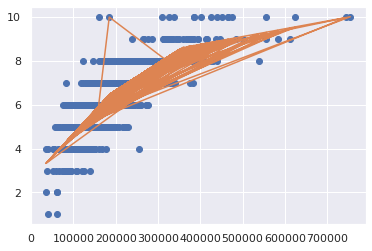

In [94]:
# plot the results
plt.figure()
plt.plot(df_train_orig['SalePrice'], df_train_orig['OverallQual'], 'o')
plt.plot(xHat, yHat, '-')
plt.show()

## Elastic Net Model

Hyperparameter Tuning - Determine best alpha

Feature Set 1

In [95]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]
for a in alphas:
    model = ElasticNet(alpha=a).fit(x1,y1)   
    score = model.score(x1, y1)
    pred_y = model.predict(x1)
    mse = mean_squared_error(y1, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}"
       .format(a, score, mse, np.sqrt(mse)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.247e+11, tolerance: 9.208e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.053e+11, tolerance: 9.208e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Alpha:0.0001, R2:0.80, MSE:1261477736.29, RMSE:35517.29
Alpha:0.0010, R2:0.80, MSE:1265731631.93, RMSE:35577.12
Alpha:0.0100, R2:0.78, MSE:1367718367.93, RMSE:36982.68
Alpha:0.1000, R2:0.71, MSE:1845135282.62, RMSE:42955.04
Alpha:0.3000, R2:0.63, MSE:2330221705.47, RMSE:48272.37
Alpha:0.5000, R2:0.58, MSE:2637656025.26, RMSE:51358.12
Alpha:0.7000, R2:0.55, MSE:2867796906.72, RMSE:53551.82
Alpha:1.0000, R2:0.50, MSE:3134779942.98, RMSE:55989.11


...I think this means my features are garbage...

Feature Set 2

In [96]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(x2,y2)   
    score = model.score(x2, y2)
    pred_y = model.predict(x2)
    mse = mean_squared_error(y2, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}"
       .format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.81, MSE:1189167469.21, RMSE:34484.31


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.704e+11, tolerance: 9.208e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.415e+11, tolerance: 9.208e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Alpha:0.0010, R2:0.81, MSE:1190406771.84, RMSE:34502.27
Alpha:0.0100, R2:0.80, MSE:1239149231.13, RMSE:35201.55
Alpha:0.1000, R2:0.72, MSE:1736556660.27, RMSE:41672.01
Alpha:0.3000, R2:0.64, MSE:2281668677.96, RMSE:47766.82
Alpha:0.5000, R2:0.59, MSE:2612662130.25, RMSE:51114.21
Alpha:0.7000, R2:0.55, MSE:2857384242.32, RMSE:53454.51
Alpha:1.0000, R2:0.50, MSE:3139329456.02, RMSE:56029.72


Feature Set 1

In [97]:
elastic_net = ElasticNet(alpha=0.0001, l1_ratio=0.5)
elastic_net.fit(x1, y1)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.247e+11, tolerance: 9.208e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


ElasticNet(alpha=0.0001)

Cross Validation

In [98]:
elasticnet_cv1 = cross_val_score(elastic_net, x1, y1,
                              scoring="neg_mean_squared_error", cv=10)

enet_rmse_scores = np.sqrt(-elasticnet_cv1)
get_cv(enet_rmse_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.754e+11, tolerance: 8.524e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.505e+11, tolerance: 8.274e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

Scores: [26199.08001718 32210.70641606 28467.3156307  45562.59487689
 42009.78510026 30906.49047576 30611.12401868 28762.49654934
 63381.53371986 28343.27172974]
Mean: 35645.439853445896
Standard deviation: 10996.36702464968


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.654e+11, tolerance: 8.469e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.609e+11, tolerance: 8.017e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

Feature Set 2

In [99]:
elastic_net2 = ElasticNet(alpha=0.0001, l1_ratio=0.5)
elastic_net2.fit(x2, y2)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.704e+11, tolerance: 9.208e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


ElasticNet(alpha=0.0001)

Cross Validation

In [100]:
elasticnet_cv2 = cross_val_score(elastic_net2, x2, y2,
                              scoring="neg_mean_squared_error", cv=10)

enet_rmse_scores = np.sqrt(-elasticnet_cv2)
get_cv(enet_rmse_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.076e+11, tolerance: 8.524e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.939e+11, tolerance: 8.274e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

Scores: [29740.14874898 32914.30039414 32855.36060575 40073.37235032
 43130.99472526 34536.80421744 32002.71704457 29163.86178112
 48525.23539035 33162.89794872]
Mean: 35610.56932066496
Standard deviation: 5952.357436369933


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.931e+11, tolerance: 8.439e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## Lasso Regression

Feature set 1

In [101]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(x1, y1)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.016e+11, tolerance: 9.208e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Lasso(alpha=0.1)

Cross Validation

In [102]:
lasso_cv = cross_val_score(lasso_reg, x1, y1,
                              scoring="neg_mean_squared_error", cv=10)

las_rmse_scores = np.sqrt(-lasso_cv)
get_cv(las_rmse_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.765e+11, tolerance: 8.274e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.835e+11, tolerance: 8.290e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

Scores: [26190.92080692 32193.76628904 28433.97972788 45608.28576203
 41949.57353077 30898.19610881 30598.3050636  28749.75803854
 63651.67164453 28304.58439101]
Mean: 35657.90413631433
Standard deviation: 11072.955715986463


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.888e+11, tolerance: 8.439e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## Ridge Regression

Feature Set 1

In [103]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(x1, y1)

Ridge(alpha=1, solver='cholesky')

Cross Validation

In [104]:
ridge_cv = cross_val_score(ridge_reg, x1, y1,
                              scoring="neg_mean_squared_error", cv=10)

rig_rmse_scores = np.sqrt(-ridge_cv)
get_cv(rig_rmse_scores)

Scores: [26415.38114776 32524.04793495 28959.17640079 45131.38818797
 42855.20915388 31176.66818657 30878.31443039 29070.77666594
 60615.36068485 28901.63034647]
Mean: 35652.795313957635
Standard deviation: 10180.884796284528


# <h2>Generate Submission</h2>

## <h3>Generate predictions and output file</h3>

Feature Set 1

In [105]:
x = df_test1
test_preds1 = lin_reg1.predict(x)

In [106]:
output = pd.DataFrame({'Id': df_test_orig.Id,
                       'SalePrice': test_preds1})
output.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Feature Set 2

In [107]:
x = df_test2
test_preds2 = lin_reg2.predict(x)

In [108]:
output = pd.DataFrame({'Id': df_test_orig.Id,
                       'SalePrice': test_preds2})
output.to_csv('submission2.csv', index=False)
files.download('submission2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Elastic Net

Feature Set 1

In [109]:
x = df_test1
test_preds3 = elastic_net.predict(x)

In [110]:
output = pd.DataFrame({'Id': df_test_orig.Id,
                       'SalePrice': test_preds3})
output.to_csv('submission3.csv', index=False)
files.download('submission3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Feature Set 2

In [111]:
x = df_test2
test_preds4 = elastic_net2.predict(x)

In [112]:
output = pd.DataFrame({'Id': df_test_orig.Id,
                       'SalePrice': test_preds4})
output.to_csv('submission4.csv', index=False)
files.download('submission4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion

The best model thus far has been feature set 1 multilinear regression. The R2 for alpha in the Elastic Net Analysis and the very high standard deviations and means tell me that I am eitheer not selecting the correct features to create a well fitted model or I am not preparing the data properly. I will explore removing some outliers in the near future to see if that improves these scores.